/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cols:  Index(['Year', 'S&P 500 (includes dividends)3', 'Real Estate2', 'US T. Bond5',
       'Baa Corporate Bond6', 'gold'],
      dtype='object')


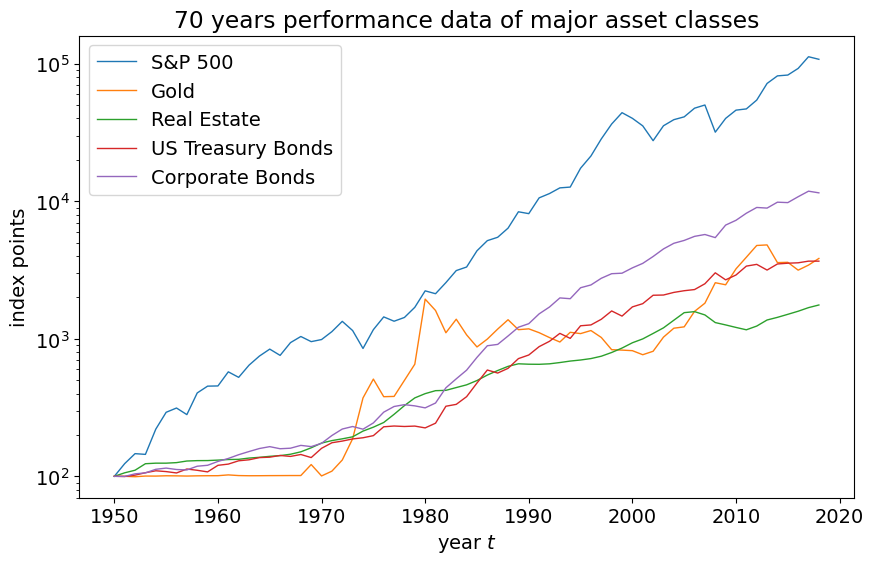

In [1]:
# to run code type:
# pyenv shell 3.9.1
# pipenv shell

# import data and prepare it (raw data cleaning)

import pandas as pd
import matplotlib.pyplot as plt
raw_data = pd.read_csv('data.csv')
columns_selection = ["Year", "S&P 500 (includes dividends)", 'US T. Bond', 'Real Estate','Inflation Rate', "Baa Corporate Bond"]
ts_selection = ["Year", "S&P 500 (includes dividends)3",'Real Estate2', 'US T. Bond5', "Baa Corporate Bond6" ]
raw = raw_data[ts_selection]
plt.rcParams.update({'font.size': 14})

for c in ts_selection[1:]:
    raw[c] = raw[c].apply(lambda x: float(x[1:].replace(",","")))
raw = raw[[int(year) < 2019 and int(year) > 1949 for year in raw["Year"]]]



data = raw_data[columns_selection]
for c in columns_selection[1:]:
    data[c] = data[c].apply(lambda x: float(x[:-1])/100 + 1)
data = data[[int(year) < 2019 and int(year) > 1949 for year in data["Year"]]]


gold = pd.read_csv("monthly.csv")
is_january = [x[-2:] == "01" for x in gold["Date"].values]

gold = gold[is_january]
data["gold"] = gold["Price"].values

data["gold"] = data["gold"].pct_change()
data["gold"] = data["gold"].apply(lambda x: x + 1)

#prepare plotting data
ts_selection.append("gold")
raw["gold"] = gold["Price"].values
for c in ts_selection[1:]:
    raw[c] = 100 / raw[c].values[0] * raw[c] 

raw_renamed = raw.copy()
print("cols: ",raw_renamed.columns)
raw_renamed.columns = ["Year","S&P 500", 'Real Estate', 'US Treasury Bonds', "Corporate Bonds","Gold", ]
raw_renamed.plot("Year", ["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds', "Corporate Bonds" ], linewidth=1.0, figsize= (10,6), logy=True, xlabel=r'year $t$', ylabel="index points",  title="70 years performance data of major asset classes")

plt.savefig('f_dataset.pdf', bbox_inches='tight' )


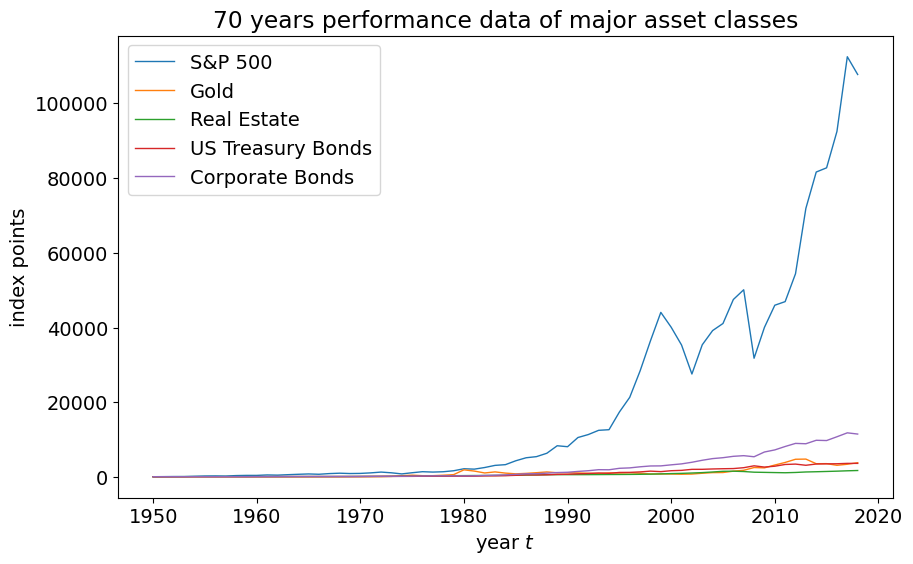

In [2]:
raw_renamed.plot("Year", ["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds', "Corporate Bonds" ], linewidth=1.0, figsize= (10,6), xlabel=r'year $t$', ylabel="index points", title="70 years performance data of major asset classes")
plt.savefig('f_dataset_norm.pdf', bbox_inches='tight' )

as is Index(['Year', 'S&P 500 (includes dividends)', 'US T. Bond', 'Real Estate',
       'Inflation Rate', 'Baa Corporate Bond', 'gold'],
      dtype='object')
Index(['Year', 'S&P 500 (includes dividends)', 'US T. Bond', 'Real Estate',
       'Inflation Rate', 'Baa Corporate Bond', 'gold'],
      dtype='object')
to be replaced Index(['Year', 'S&P 500 (includes dividends)', 'US T. Bond', 'Real Estate',
       'Baa Corporate Bond', 'gold'],
      dtype='object')


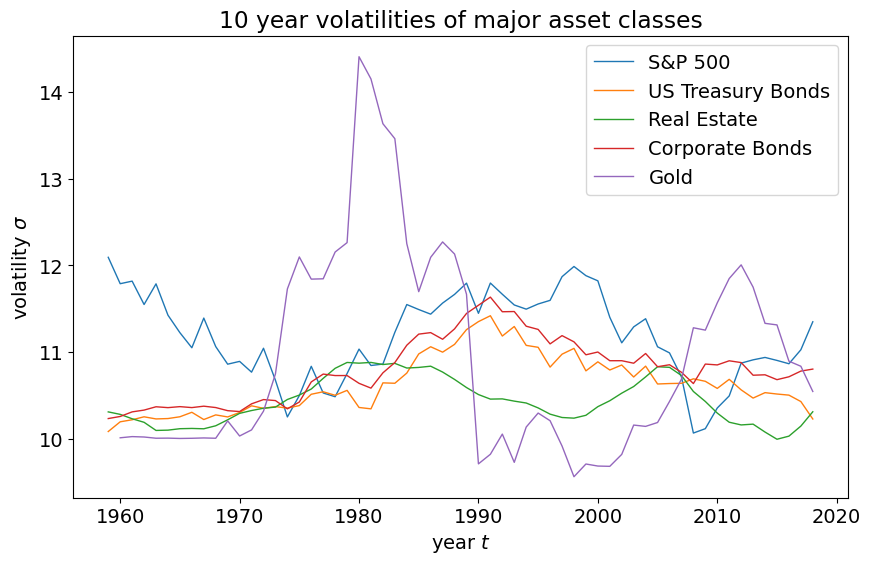

In [3]:
# plot volatilities
import matplotlib.pyplot as plt
volas = data.copy()
print("as is", data.columns)
cols = list(volas.columns)
cols.remove("Year")
for col in cols:
    volas[col] = volas[col].rolling(window=10).sum()
print(volas.columns)
del volas["Inflation Rate"]
print("to be replaced", volas.columns)
volas.columns = ["Year","S&P 500", 'US Treasury Bonds', 'Real Estate', "Corporate Bonds" ,"Gold"]
#del volas["Baa Corporate Bond"]
volas.columns
volas.plot("Year", ["S&P 500", 'US Treasury Bonds', 'Real Estate',"Corporate Bonds","Gold" ], linewidth=1.0, figsize= (10,6), xlabel=r'year $t$', ylabel=r'volatility $\sigma$', title="10 year volatilities of major asset classes")
plt.savefig('f_10_yr_volas.pdf', bbox_inches='tight' )

In [4]:
# Definition of custom RL environment

import gym
from gym import spaces
import numpy as np
import math

def get_random_integer_between(a,b,c=0):
  np.random.seed(c)
  no = (min(max(np.random.normal(0,1), -4),4)/4) * ((b-a)/2) + a + (b-a)/2
  no = int(round(no,0))
  return no

class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    def __init__(self, data, rebalancing=False, risk_enforcement = 1):
        super(CustomEnv, self).__init__()
        self.data = data
        self.rebalancing = rebalancing
        self.current_step = 0
        self.horizon_preference = 5
        self.risk_preference = 50
        self.current_point_in_time = 11
        self.reward_range = (-np.inf, np.inf) 
        self.risk_enforcement = risk_enforcement

        # Space of possible actions:
        self.action_space = spaces.Box(low=0.001, high=1, shape=(4,))
        if rebalancing == "learn":
          self.action_space = spaces.Box(low=0.001, high=1, shape=(5,))
       


        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(58, ), dtype=np.float16)
    
    def get_obs_sample(self):
        return self.observation_space.sample()

    def get_random_preferences(self):
      return np.array([get_random_integer_between(0,10), get_random_integer_between(0,100)],dtype=np.float32)

    def set_current_observation(self, observation):
      self.current_observation = observation

    def get_current_observation(self, current_point_in_time=False, risk_preference=False, horizon_preference=False):
      self.current_point_in_time = current_point_in_time if current_point_in_time else get_random_integer_between(11,57, self.current_step)#np.random.randint(11,57)
      self.risk_preference = risk_preference if risk_preference else get_random_integer_between(0,100, self.current_step)#np.random.randint(0,100)   
      self.horizon_preference = horizon_preference if horizon_preference else get_random_integer_between(5,10, self.current_step)#np.random.randint(5,10)
      self.current_asset_data = np.array(self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]].iloc[self.current_point_in_time - 10: self.current_point_in_time].values,dtype=np.float32)
      self.std_devs = []
    
      for c in ["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]:
      
        self.std_devs.append(self.data[[c]].iloc[self.current_point_in_time - 10: self.current_point_in_time].std().values[0])
      
      self.std_devs = np.array(self.std_devs,dtype=np.float32 )
     
      self.current_observation =  np.concatenate((
        self.current_asset_data.flatten(),
        np.array([self.risk_preference, self.horizon_preference, self.current_point_in_time],dtype=np.float32),
        self.std_devs),
        axis=None
        )
   
      return self.current_observation


    def reset(self):
  
      return self.get_current_observation()

    
    def _next_observation(self):
      
      self.current_step += 1
      self.current_point_in_time = get_random_integer_between(11,57,self.current_step)
      self.risk_preference=get_random_integer_between(0,100,self.current_step)
      self.horizon_preference=get_random_integer_between(5,10,self.current_step)

      next_observation = self.get_current_observation(current_point_in_time=get_random_integer_between(11,57,self.current_step), risk_preference=get_random_integer_between(0,100,self.current_step), horizon_preference=get_random_integer_between(5,10,self.current_step))

      return next_observation

    def _calculate_reward(self, action, *args, **kwargs):
  
      relevant_timeseries = self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond"]].iloc[self.current_point_in_time: self.current_point_in_time + self.horizon_preference]
    
      reb_action = 0
      if self.rebalancing == "learn":
        reb_action = action[4]
        action = np.array([action[0],action[1],action[2],action[3]])
      action_sum = action.sum()
      asset_allocation = [action[0]/action_sum, action[1]/action_sum, action[2]/action_sum, action[3]/action_sum]

      if self.rebalancing:
        aggregated_timeseries = []
        i = 0
        for step in relevant_timeseries.iterrows():
          if i == 0:
          # calculate asset allocation after step
            aggregated_timeseries.append(
              asset_allocation[i] * step[1].values
            ) 
            i += 1
          else:
            resulting_allocation = [aggregated_timeseries[-1][i] / np.array(aggregated_timeseries[-1]).sum() for i in [0,1,2,3]]
          
           
            max_deviation = abs(max(([(resulting_allocation[i] - asset_allocation[i])/asset_allocation[i] for i in [0,1,2,3]]), key=abs))
            if (self.rebalancing == "learn" and max_deviation > reb_action) or (self.rebalancing not in [False, "learn"] and max_deviation > self.rebalancing):
           
              # do rebalacing
            
              current_portfolio_value = np.array(aggregated_timeseries[-1]).sum()
              rebalanced_portfolio = [asset_allocation[i] * current_portfolio_value for i in [0,1,2,3]]
              aggregated_timeseries.append(
                rebalanced_portfolio * (step[1].values)
              ) 
              
            else:
              # let go
              aggregated_timeseries.append(
                aggregated_timeseries[-1] * (step[1].values)
              ) 
        aggregated_timeseries_calc = pd.Series([i.sum() for i in aggregated_timeseries]).pct_change().values
        
        increments = np.array([1 + i for i in aggregated_timeseries_calc][1:])
        aggregated_timeseries = increments.cumprod()
     
      else:

        increments = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"].values-1) \
        +((action[1] / action.sum())*(relevant_timeseries["gold"].values-1))
        + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"].values-1)) \
            + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"].values-1)) 
        
        aggregated_timeseries = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"].values.cumprod()-1) \
        +((action[1] / action.sum())*(relevant_timeseries["gold"].values.cumprod()-1)) \
          + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"].values.cumprod()-1)) \
            + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"].values.cumprod()-1)) 
   
        aggregated_timeseries = aggregated_timeseries[1:]
   
      # penalty for missing diversification (beta)
      unrepresented_assets_penality = 1
      for act in action:
        unrepresented_assets_penality *= 1 - 5.5* (0.05 - min(act, 0.05))
          
      if (self.risk_preference * np.array(aggregated_timeseries).std()) != 0:
        vola_factor = 3 * np.array(increments)[np.where(np.array(increments) < 1)].std()
        if vola_factor == [] or vola_factor == np.nan or math.isnan(vola_factor):
          vola_factor = 0
        
        reward = list(np.array(aggregated_timeseries))[-1] - ((self.risk_enforcement * self.risk_preference) * vola_factor if vola_factor else 1)#/5.25)#/10)
        reward *= unrepresented_assets_penality
       
      else:
        reward = 0
      if reward == np.nan or math.isinf(reward):
        reward = 0
      else:
    
        return reward

    def calculate_revenue(self, action, *args, **kwargs):
      relevant_timeseries = self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]].iloc[self.current_point_in_time: self.current_point_in_time + self.horizon_preference]
   
     
      aggregated_timeseries = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"]-1) \
      +((action[1] / action.sum())*(relevant_timeseries["gold"]-1)) \
         + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"]-1)) \
          + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"]-1)) 
      
      reward = list(aggregated_timeseries.cumprod())[-1]
      
      if reward == np.nan or math.isinf(reward):
        return 0
      else:
        return reward


    
    def step(self, action):
      self.reward = self._calculate_reward(action)
      return self._next_observation(), self.reward, self.current_step < 2500, {}


    def render(self, mode='human'):
      pass


In [5]:
np.array([1,2,3])[np.where(np.array([1,2,3]) < 4)]
math.isnan(np.array([]).std())

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


True

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# test environment
testEnv  = CustomEnv(data, rebalancing=False)

testEnvReb = CustomEnv(data, rebalancing=False)
testEnvReb1 = CustomEnv(data, rebalancing=0.1)
testEnvReb2 = CustomEnv(data, rebalancing="learn")

testEnvReb.get_current_observation(current_point_in_time=11, risk_preference=50, horizon_preference=50)
testEnvReb1.get_current_observation(current_point_in_time=11, risk_preference=50, horizon_preference=50)

rew_reb = testEnvReb._calculate_reward(np.array([1,1,1,1]))
rew_reb1 = testEnvReb1._calculate_reward(np.array([1,1,1,1]))


rew = testEnv._calculate_reward(np.array([1,1,1,1]))





/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:180: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


<>:4: DeprecationWarning: invalid escape sequence \d


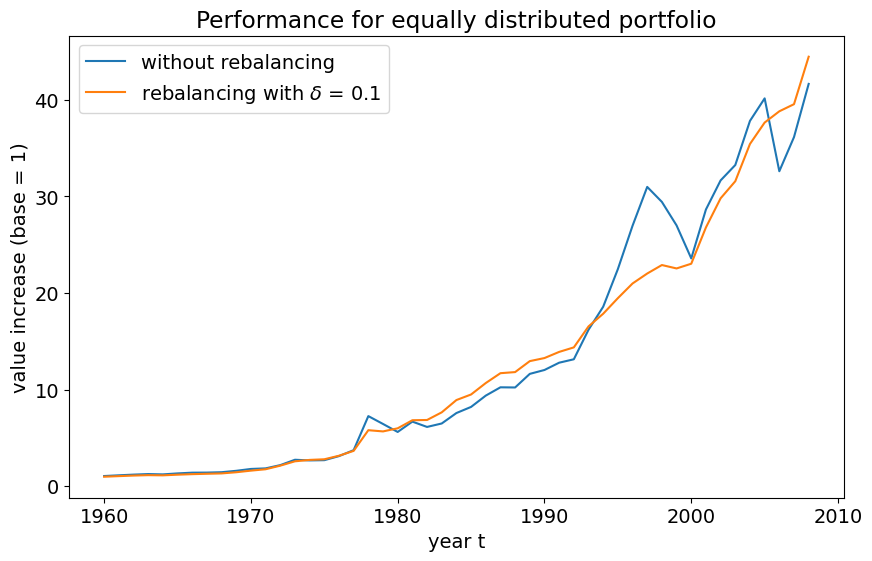

In [9]:
# plot rebalancing demonstration
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6), facecolor="white")
plt.plot(range(1960, 2009), [1.062132132583357, 1.136646594450847, 1.2084002493890538, 1.2662539551978795, 1.2317994780069181, 1.3328610482867729, 1.4095489629145195, 1.4181329703613368, 1.457422717458834, 1.602176809015465, 1.7946549906366853, 1.853900866330217, 2.1904057078250054, 2.7462963273946355, 2.67850556836324, 2.7023136271229564, 3.1226355192840503, 3.7403017935836336, 7.263253483210841, 6.4507334258449855, 5.623220836733919, 6.693844427308683, 6.143038315482216, 6.500192087014691, 7.580704844847418, 8.215436924902697, 9.384155453028322, 10.244184670626627, 10.227761678796995, 11.634737191576857, 12.037295626339294, 12.791037220707926, 13.145823687908557, 16.198665754582546, 18.58271955480025, 22.47708757081691, 26.963331845727094, 30.98617909543078, 29.43301844721339, 27.000440306131246, 23.585550369090935, 28.648071072955496, 31.658389851687534, 33.25024546717012, 37.81768459887536, 40.14966707060115, 32.607807822629375, 36.14116721948979, 41.647291091623856], label = "without rebalancing")
plt.plot(range(1960, 2009), [0.9901878515185603, 1.0508360618982002, 1.1101227497077724, 1.151537353564074, 1.132171086082106, 1.2013295824676222, 1.2560201117094605, 1.2956258616706335, 1.3317810739797482, 1.4536772376813165, 1.619717474147161, 1.7633345646905672, 2.1348514745773817, 2.585599669503243, 2.7307240002782787, 2.7950595218143692, 3.1609603579900054, 3.6665478758292664, 5.805429817336246, 5.679022602954878, 6.000732073459705, 6.83656512331041, 6.862233609070333, 7.653271010432953, 8.925288042096298, 9.502101146318788, 10.685149803398051, 11.705709387560589, 11.819625339435136, 12.954214501678887, 13.272538508335007, 13.908344637343212, 14.376538374096722, 16.5444235789648, 17.859678032412088, 19.471816029814068, 20.989988695644936, 22.021250124416145, 22.899642476471715, 22.546679095856817, 23.03496152122136, 26.790438338467126, 29.805654577912854, 31.572903668496853, 35.42979419714283, 37.64572661869575, 38.811746910039176, 39.54764349301106, 44.460279509702914], label = "rebalancing with $\delta$ = 0.1")
plt.legend()
plt.title("Performance for equally distributed portfolio")
plt.xlabel("year t")
plt.grid(False)
plt.ylabel("value increase (base = 1)")
plt.savefig('f_rebalancing_demo.pdf', bbox_inches='tight' )
plt.show()



In [10]:
# imports
import json
import datetime as dt
from stable_baselines.common.policies import MlpPolicy, CnnPolicy, MlpLnLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

from stable_baselines3 import A2C, DDPG, SAC, TD3
from stable_baselines3 import PPO as PPO1



/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/tensorflow_core/python/pywrap_tensorflow_internal.py:15: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/tensorflow_core/python/framework/dtypes.py:597: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/tensorflow_core/python/framework/dtypes.py:605: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/torch/utils/tensorboard/__init__.py:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [11]:
# create validation set
file_name = "validation_set.csv"
test_env = CustomEnv(data)
def create_and_save_val_set(file_name, size=1000):
        data = []
        for i in range(0,1000):
               
                np.random.seed(i)
                obs = [np.random.randint(11,57),get_random_integer_between(0,100, i), get_random_integer_between(5,10, i)]
                data.append(obs)
          
        pd.DataFrame(data).to_csv(file_name)

create_and_save_val_set(file_name)

val_data = pd.read_csv("./"+file_name)
val_data



,Unnamed: 0,0,1,2
0,0,55,72,9
1,1,48,70,9
2,2,51,45,7
3,3,53,72,9
4,4,16,51,8
...,...,...,...,...
995,995,20,42,7
996,996,25,42,7
997,997,17,61,8
998,998,42,51,8


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.03`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  after removing the cwd from sys.path.


11

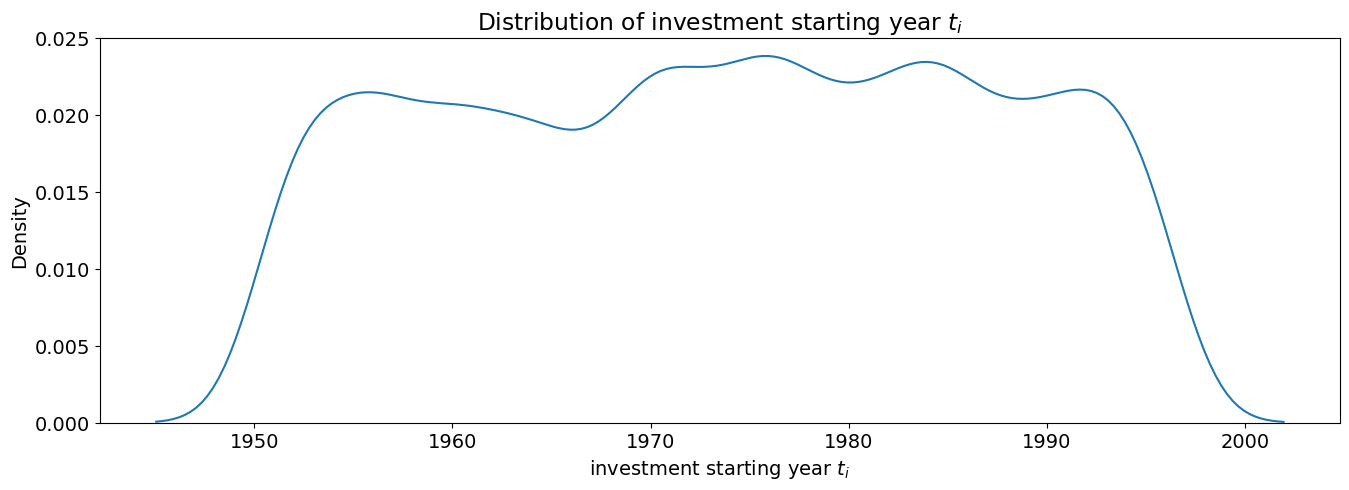

In [12]:
# plot starting year distribution
val_data["0"].values
plt.rcParams["figure.figsize"] = (16,5)
sns.kdeplot(np.array( [x + 1940 for x in val_data["0"].values]), bw=0.03, bw_adjust=5)
plt.title("Distribution of investment starting year $t_i$")
plt.xlabel("investment starting year $t_i$")

plt.savefig('f_dist_starting_year.pdf', bbox_inches='tight' )
val_data["0"].min()

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.4`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  This is separate from the ipykernel package so we can avoid doing imports until


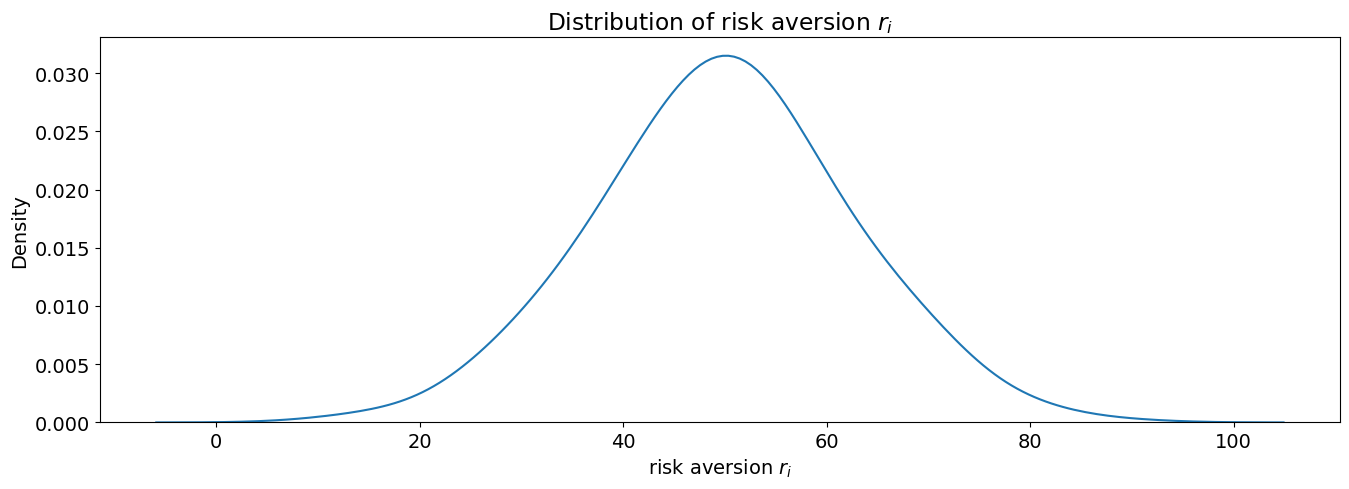

In [13]:
# print horizon distribution
val_data["1"].values
sns.kdeplot(np.array(val_data["1"].values), bw=0.4)
plt.title("Distribution of risk aversion $r_i$")
plt.xlabel("risk aversion $r_i$")
plt.savefig('f_dist_investment_starting_year.pdf', bbox_inches='tight' )


<>:12: DeprecationWarning: invalid escape sequence \s
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.4`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  """


lower bound: 37.587755125569636
upper bound: 62.412244874430364


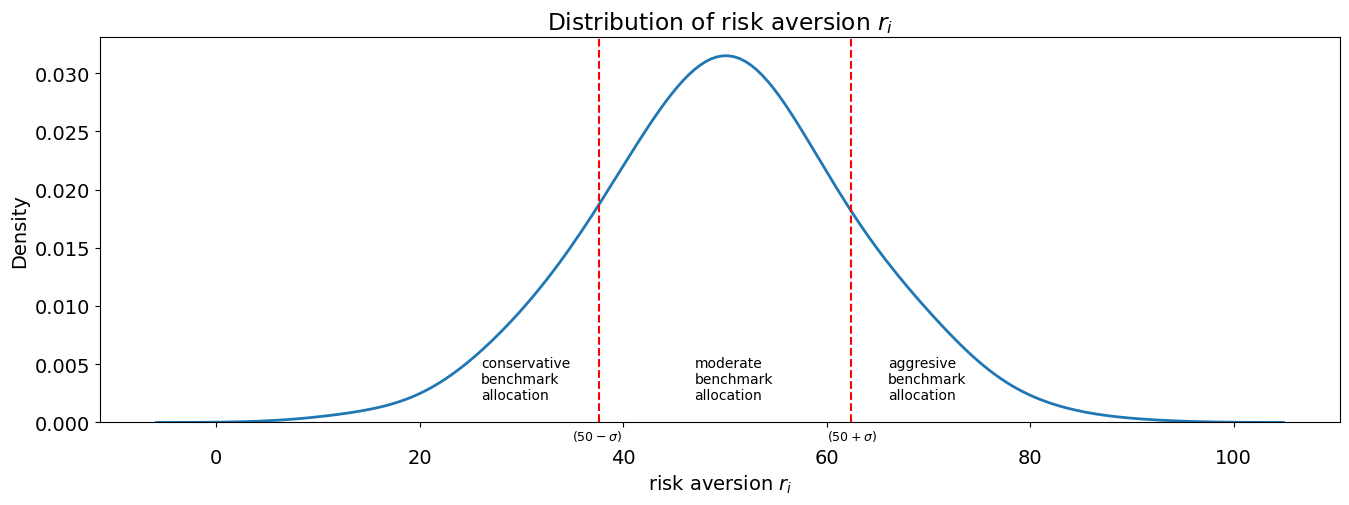

In [14]:
# print risk distribution
import matplotlib.pyplot as plt
val_data["1"].values
riskData = pd.DataFrame({"Risk Preference":np.array(val_data["1"].values) })
ax = sns.kdeplot(riskData, x="Risk Preference", bw=0.4, linewidth=2)
plt.title("Distribution of risk aversion $r_i$")
plt.xlabel("risk aversion $r_i$")
ax.tick_params(axis='x', which='major', pad=15)
ax.text(26, 0.002, "conservative\nbenchmark\nallocation", ha ='left', fontsize = 10)
ax.text(47, 0.002, "moderate\nbenchmark\nallocation", ha ='left', fontsize = 10)
ax.text(66, 0.002, "aggresive\nbenchmark\nallocation", ha ='left', fontsize = 10)
ax.text(60, -0.0015, "$(50 + \sigma)$", ha ='left', fontsize = 9)
ax.text(35, -0.0015, "$(50 - \sigma)$", ha ='left', fontsize = 9)
lower_risk_bound = 50-val_data["1"].std()
upper_risk_bound = 50+val_data["1"].std()
plt.axvline(x=lower_risk_bound, color='r', label='sigma', ls='--')
plt.axvline(x=upper_risk_bound, color='r', label='sigma', ls='--')

print("lower bound: {}\nupper bound: {}".format(lower_risk_bound, upper_risk_bound))
plt.savefig('f_dist_risk_aversion.pdf', bbox_inches='tight' )

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  import sys


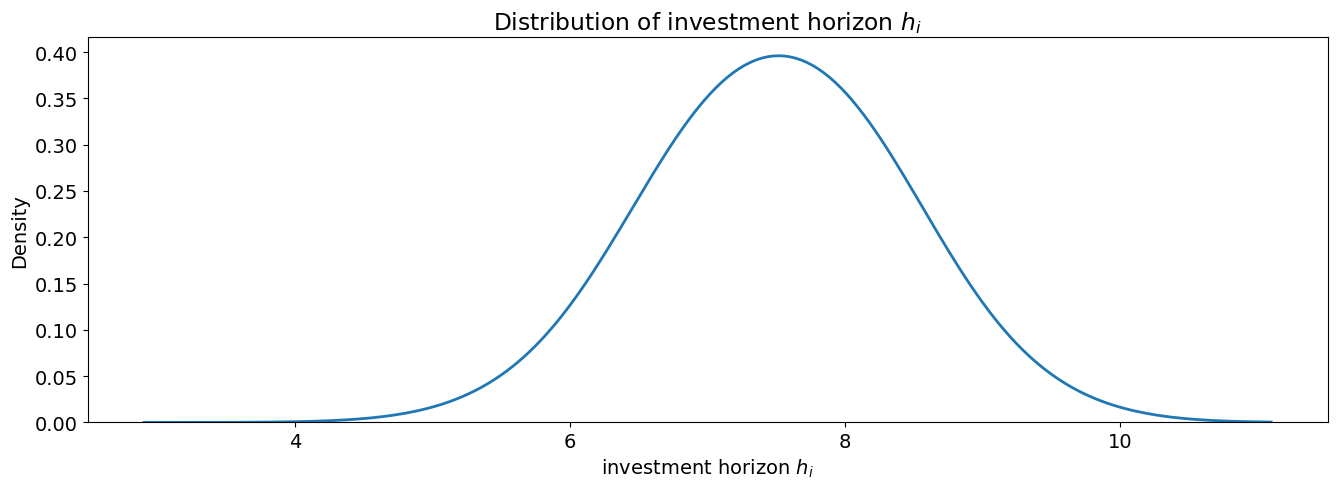

In [15]:
# print distribution

riskData = pd.DataFrame({"Horizon Preference":np.array(val_data["2"].values) })
ax = sns.kdeplot(riskData, x="Horizon Preference", bw=1, linewidth=2)
plt.title("Distribution of investment horizon $h_i$")
plt.xlabel("investment horizon $h_i$")
plt.savefig('f_dist_investment_horizon.pdf', bbox_inches='tight' )


In [16]:
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from itertools import product

# Training Environment
env = CustomEnv(data)
eval_env = CustomEnv(data)
# Evaluation Callback (should it be on saparate environment? https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=6, min_evals=5, verbose=0)
eval_callback = EvalCallback(eval_env, eval_freq=80, callback_after_eval=stop_train_callback, verbose=0)

env.get_current_observation()


models = {
	"PPO1":PPO1,
	"A2C": A2C, 
	
	"DDPG":DDPG,
	"SAC":SAC,
	"TD3":TD3,

	}




def calculate_score_on_val(model, rebalancing=False, risk_enforcement=1):

	env = CustomEnv(data, rebalancing=rebalancing, risk_enforcement=risk_enforcement)
	actions = []
	for i in val_data.iterrows():
		row = i[1].values[1:]
		env.current_point_in_time = row[0]
		env.risk_preference = row[1]
		env.horizon_preference=row[2]
		action = model.predict(env.get_current_observation(row[0],row[1],row[2]), deterministic=True)
		
		actions.append(action[0])
		try:
			score += env._calculate_reward(action[0])
			revenue += env.calculate_revenue(action[0])
			
			
		except Exception as e:
			print(e)
			score = 0
			revenue = 0
	average_action = np.array(actions).mean(axis=0)
	return score, average_action, revenue, actions



models_1={}

In [17]:

# broad search
import os

scores = {}
average_actions = {}
revenues = {}
actions = {}

total_score = 0

learning_rates = [0.01, 0.0001, 0.00001]
batch_sizes = [1,2,3,5]
total_timesteps = 1300

performance_data = {"agent": [], "learning rate":[], "batch size": [], "RMSProp": [], "revenue":[], "reward":[]}

for model, learning_rate, batch_size in product(models, learning_rates, batch_sizes):
	if model == "A2C":
		models_dir = "models/A2C"
		logdir = "logs"

		if not os.path.exists(models_dir):
			os.makedirs(models_dir)

		if not os.path.exists(logdir):
			os.makedirs(logdir)
		print(model)
		for use_rms_prop in [True, False]:
			m = models[model]('MlpPolicy',env,learning_rate = learning_rate, n_steps=batch_size, use_rms_prop = use_rms_prop, seed=1)
			m.learn(total_timesteps=total_timesteps, callback=eval_callback)
			key = "{}_{}_{}_{}".format(model,str(learning_rate), str(use_rms_prop), str(batch_size))
			scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
			performance_data["agent"].append(model)
			performance_data["learning rate"].append(learning_rate)
			performance_data["batch size"].append(batch_size)
			performance_data["RMSProp"].append(use_rms_prop if (use_rms_prop==True or use_rms_prop == False) else "n/a")
			performance_data["reward"].append(round(scores[key],2))
			performance_data["revenue"].append(round(revenues[key],2))
			models_1[key] = m



	if model == "PPO1":
		print(model)
		m = models[model]('MlpPolicy',env,learning_rate=learning_rate, batch_size=batch_size + 1, seed=1)
		m.learn(total_timesteps=total_timesteps, callback=None)#eval_callback)
		key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
		scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
		performance_data["agent"].append(model)
		performance_data["learning rate"].append(learning_rate)
		performance_data["batch size"].append(batch_size)
		performance_data["RMSProp"].append("n/a")
		performance_data["reward"].append(round(scores[key],2))
		performance_data["revenue"].append(round(revenues[key],2))
		models_1[key] = m

	print("{} score is {}".format(key if key else "", scores[key] if key else ""))

for model in ["SAC"]:#"DDPG", 
	for learning_rate in learning_rates:
		for batch_size in batch_sizes:
			print(model)
			n_actions = env.action_space.shape[-1]
			action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
			m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
			m.learn(total_timesteps=total_timesteps, callback=eval_callback)
			key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
			scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
			print("{} score is {}".format(key, scores[key]))
			performance_data["agent"].append(model)
			performance_data["learning rate"].append(learning_rate)
			performance_data["batch size"].append(batch_size)
			performance_data["RMSProp"].append("n/a")
			performance_data["reward"].append(round(scores[key],2))
			performance_data["revenue"].append(round(revenues[key],2))
			models_1[key] = m


PPO1


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/gym/core.py:269: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:180: DeprecationWarning: The truth v

local variable 'score' referenced before assignment
PPO1_0.01_-_1 score is 45.36502602288914
PPO1


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/stable_baselines3/ppo/ppo.py:147: UserWarning: You have specified a mini-batch size of 3, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2048`, after every 682 untruncated mini-batches, there will be a truncated mini-batch of size 2
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2048 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


local variable 'score' referenced before assignment
PPO1_0.01_-_2 score is 707.5139461898925
PPO1
local variable 'score' referenced before assignment
PPO1_0.01_-_3 score is -761.5938037529577
PPO1


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/stable_baselines3/ppo/ppo.py:147: UserWarning: You have specified a mini-batch size of 6, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2048`, after every 341 untruncated mini-batches, there will be a truncated mini-batch of size 2
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2048 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


local variable 'score' referenced before assignment
PPO1_0.01_-_5 score is 45.36502602288914
PPO1
local variable 'score' referenced before assignment
PPO1_0.0001_-_1 score is -226.99574875388552
PPO1
local variable 'score' referenced before assignment
PPO1_0.0001_-_2 score is 110.99721663342925
PPO1
local variable 'score' referenced before assignment
PPO1_0.0001_-_3 score is -401.07687713742337
PPO1
local variable 'score' referenced before assignment
PPO1_0.0001_-_5 score is -179.07199278282812
PPO1
local variable 'score' referenced before assignment
PPO1_1e-05_-_1 score is -61.921979496546676
PPO1
local variable 'score' referenced before assignment
PPO1_1e-05_-_2 score is -217.77852838664558
PPO1
local variable 'score' referenced before assignment
PPO1_1e-05_-_3 score is -264.19031995126574
PPO1
local variable 'score' referenced before assignment
PPO1_1e-05_-_5 score is -338.00142754845007
A2C


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.01_False_1 score is 707.5139461898925
A2C
local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.01_False_2 score is 705.4313116759624
A2C
local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.01_False_3 score is 698.6804047820153
A2C
local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.01_False_5 score is 469.79996282437247
A2C
local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.0001_False_1 score is 491.9507115225373
A2C
local variable 'score' referenced before assignment
local variable 'score' referenced before assignment
A2C_0.0001_False_2 score is 127.2265923588623
A2C
local variable 'score' referenced before assignment
local variable 'score' referenc

In [18]:
# print to latex table markup
from pylatex import Document, Package, Section, NoEscape
import pandas as pd
perf_data = pd.DataFrame(performance_data, ).drop(["revenue"], axis=1).sort_values("reward", ascending=False).reset_index().drop("index",axis=1)
perf_data.index = np.arange(1, len(perf_data) + 1)
perf_data['reward'].astype('str')

pd.options.display.float_format = '{:12.0e}'.format

pd.set_option('display.float_format', lambda x: '%.0e' % x if (x < 1 and x > 0) else '%.2f' % x)
NoEscape(perf_data.to_latex())


NoEscape(\begin{tabular}{llrrlr}
\toprule
{} & agent &  learning rate &  batch size & RMSProp &  reward \\
\midrule
1  &   SAC &          1e-05 &           1 &     n/a &  778.70 \\
2  &   SAC &          1e-05 &           3 &     n/a &  751.67 \\
3  &   SAC &          1e-05 &           2 &     n/a &  733.81 \\
4  &   SAC &          1e-05 &           5 &     n/a &  718.64 \\
5  &   A2C &          1e-02 &           1 &   False &  707.51 \\
6  &   A2C &          1e-02 &           3 &    True &  707.51 \\
7  &   A2C &          1e-02 &           2 &    True &  707.51 \\
8  &  PPO1 &          1e-02 &           2 &     n/a &  707.51 \\
9  &   A2C &          1e-02 &           1 &    True &  705.43 \\
10 &   A2C &          1e-02 &           2 &   False &  705.43 \\
11 &   A2C &          1e-02 &           3 &   False &  698.68 \\
12 &   A2C &          1e-04 &           1 &    True &  689.72 \\
13 &   SAC &          1e-02 &           5 &     n/a &  633.41 \\
14 &   SAC &          1e-02 &          

In [19]:
%tensorboard --logdir logs/

UsageError: Line magic function `%tensorboard` not found.


In [20]:
print(dir(m))
m.tensorboard_log

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_convert_train_freq', '_create_aliases', '_current_progress_remaining', '_custom_logger', '_dump_logs', '_episode_num', '_episode_storage', '_excluded_save_params', '_get_eval_env', '_get_policy_from_name', '_get_torch_save_params', '_init_callback', '_last_episode_starts', '_last_obs', '_last_original_obs', '_logger', '_n_updates', '_num_timesteps_at_start', '_on_step', '_sample_action', '_setup_learn', '_setup_lr_schedule', '_setup_model', '_store_transition', '_total_timesteps', '_update_current_progress_remaining', '_update_info_buffer', '_update_learning_rate', '_vec_normali

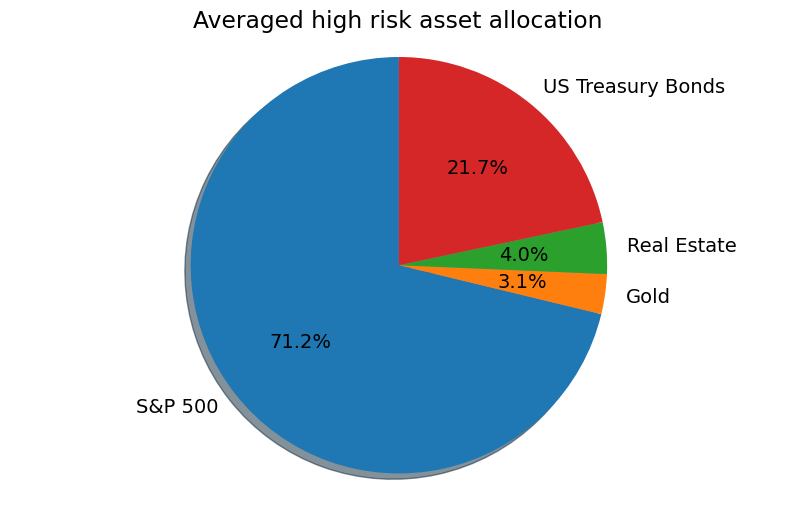

In [21]:

#prepare benchmark
benchmark_aggresive = ([(.65 + .75 + .100 + .80)/4,(0.05+0.05+0+0)/4, (.3+.2+.0+.2)/4])
np.array(benchmark_aggresive).sum()
benchmark_aggresive = [i/np.array(benchmark_aggresive).sum() for i in benchmark_aggresive]
benchmark_aggresive = [0.7419354838709677*0.96, 0.03225806451612904*0.96,0.04, 0.22580645161290325*0.96]
np.array(benchmark_aggresive).sum()
benchmark_aggresive
fig1, ax1 = plt.subplots(figsize=(10,6))

ax1.pie(benchmark_aggresive, labels=["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title("Averaged high risk asset allocation")
plt.savefig('f_benchmark_aggressive.pdf', bbox_inches='tight')

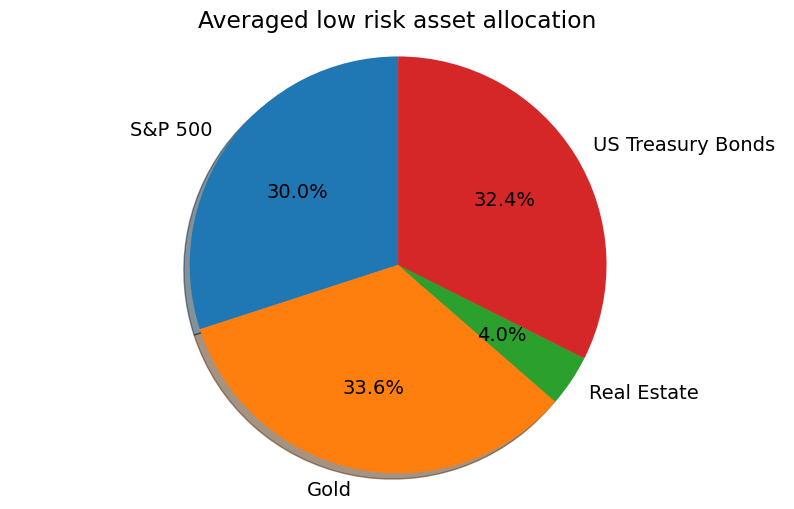

In [22]:
#prepare benchmark
benchmark_conservative = ([(.2 + .45 + .2 + .4)/4,(0.5+0.2+0.5+0.2)/4, (.3+.35+.3+.4)/4])
np.array(benchmark_conservative).sum()
benchmark_conservative = [i/np.array(benchmark_conservative).sum() for i in benchmark_conservative]
benchmark_conservative = [0.3125*0.96, 0.35*0.96, 0.04, 0.3375*0.96]
np.array(benchmark_conservative).sum()
benchmark_conservative
fig1, ax1 = plt.subplots(figsize=(10,6))

ax1.pie(benchmark_conservative, labels=["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title("Averaged low risk asset allocation")
plt.savefig('f_benchmark_conservative.pdf', bbox_inches='tight')

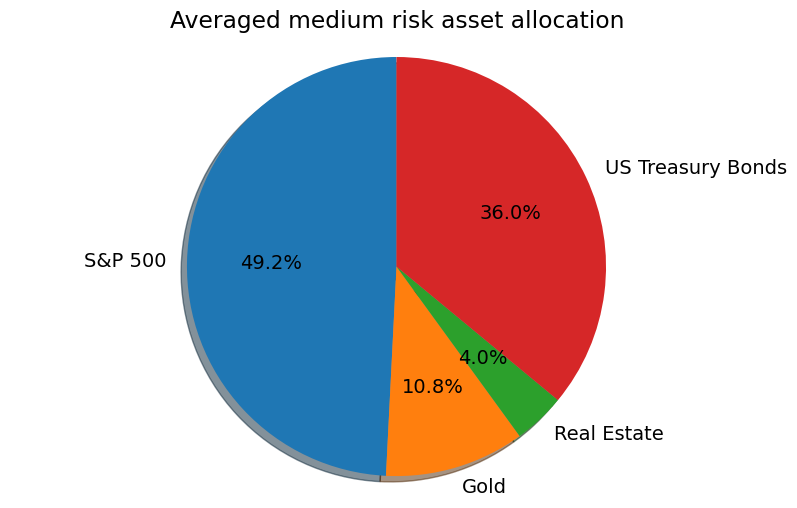

In [23]:
#prepare benchmark

benchmark = np.array([0.492, 0.108, 0.04, 0.36])


import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(10,6))

ax1.pie(benchmark, labels=["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title("Averaged medium risk asset allocation")
plt.savefig('f_benchmark_moderate.pdf', bbox_inches='tight')


Text(0.5, 1.0, 'Averaged low risk asset allocation')

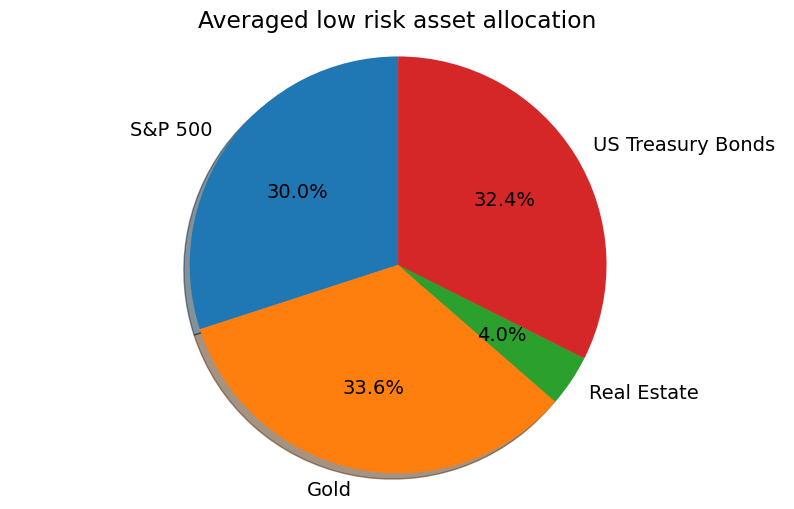

In [24]:
#prepare benchmark

benchmark = np.array([0.492, 0.108, 0.04, 0.36])


import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(10,6))

ax1.pie(benchmark_conservative, labels=["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title("Averaged low risk asset allocation")



Text(0.5, 1.0, 'Averaged high risk asset allocation')

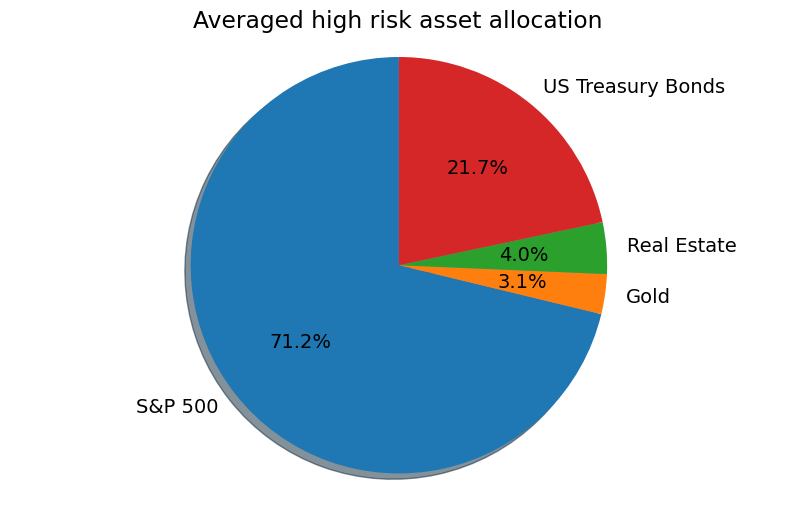

In [25]:
# prepare benchmark
benchmark = np.array([0.492, 0.108, 0.04, 0.36])


import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(10,6))

ax1.pie(benchmark_aggresive, labels=["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title("Averaged high risk asset allocation")



In [26]:
# calculate benchmark score

scores["Benchmark"] = 0
revenues["Benchmark"] = 0

for i in val_data.iterrows():
		env.set_current_observation = i[1].values
		try:
			
			env.current_point_in_time = i[1].values[1]
			env.risk_preference=i[1].values[2]
			env.horizon_preference=i[1].values[3]
			
			if i[1].values[2] <= lower_risk_bound:
				
				scores["Benchmark"] += env._calculate_reward(np.array(benchmark_conservative))
			elif i[1].values[2] >= upper_risk_bound:
				scores["Benchmark"] += env._calculate_reward(np.array(benchmark_aggresive))
				
			else:
				scores["Benchmark"] += env._calculate_reward(benchmark)
				
		except:
			scores["Benchmark"] = 0
			revenues["Benchmark"] = 0

print("Benchmark score is {}".format(scores["Benchmark"]))

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:180: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Benchmark score is 161.48745323524201


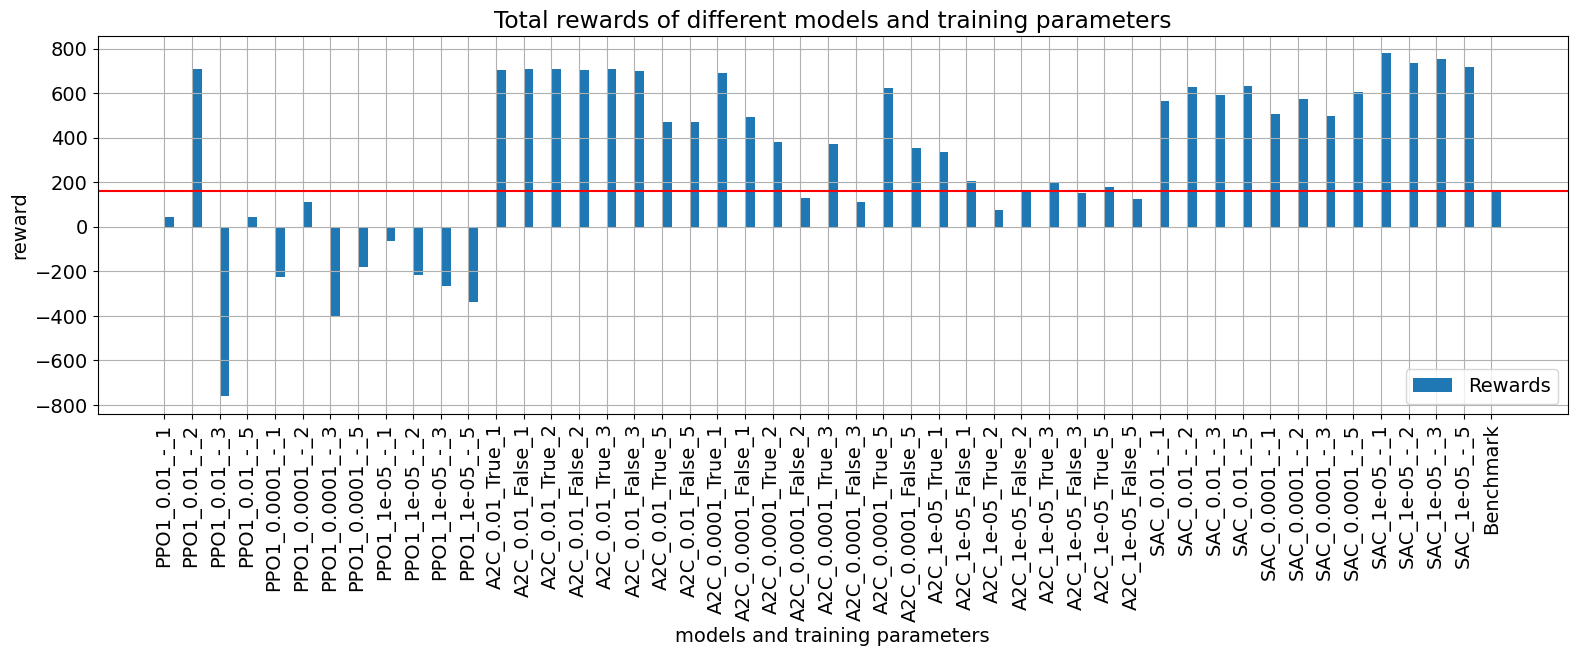

In [27]:

# plot broad search results

plt.rcParams["figure.figsize"] = (16,5)
fig1, ax1 = plt.subplots()
labels = [k for k in scores]
x = np.arange(len(labels))

b2 = ax1.bar(x + 0.175, [scores[k] for k in scores], 0.35, label="Rewards")
ax1.set_xticks(x, labels)
ax1.set_title("Total rewards of different models and training parameters")

ax1.set_ylabel("reward")
ax1.set_xlabel("models and training parameters")
fig1.tight_layout()
plt.xticks(rotation='vertical')
plt.axhline(y=scores["Benchmark"], color='r', linestyle='-')
plt.legend()
plt.rc('grid', linestyle="--", color='lightgrey')
plt.grid()
plt.savefig('f_rough_search.pdf', bbox_inches='tight' )
plt.show()


In [28]:

vals = [scores[s] for s in scores.keys()]
sorted(zip(vals, scores.keys()), reverse=True)


[(778.6956922161626, 'SAC_1e-05_-_1'),
 (751.6701962665272, 'SAC_1e-05_-_3'),
 (733.806406421153, 'SAC_1e-05_-_2'),
 (718.6360770523003, 'SAC_1e-05_-_5'),
 (707.5139461898925, 'PPO1_0.01_-_2'),
 (707.5139461898925, 'A2C_0.01_True_3'),
 (707.5139461898925, 'A2C_0.01_True_2'),
 (707.5139461898925, 'A2C_0.01_False_1'),
 (705.4313116759624, 'A2C_0.01_True_1'),
 (705.4313116759624, 'A2C_0.01_False_2'),
 (698.6804047820153, 'A2C_0.01_False_3'),
 (689.7152455017866, 'A2C_0.0001_True_1'),
 (633.4131159160299, 'SAC_0.01_-_5'),
 (628.9897038888857, 'SAC_0.01_-_2'),
 (624.9577470551202, 'A2C_0.0001_True_5'),
 (603.2085211291351, 'SAC_0.0001_-_5'),
 (590.6264097184837, 'SAC_0.01_-_3'),
 (573.0871846415187, 'SAC_0.0001_-_2'),
 (564.8294107402951, 'SAC_0.01_-_1'),
 (508.54985875481054, 'SAC_0.0001_-_1'),
 (498.2997504554173, 'SAC_0.0001_-_3'),
 (491.9507115225373, 'A2C_0.0001_False_1'),
 (469.79996282437247, 'A2C_0.01_True_5'),
 (469.79996282437247, 'A2C_0.01_False_5'),
 (378.58796311394434, 'A2C_0.

[[0.283547, 0.070236385, 0.1265634, 0.17029218, 0.19742048, 0.21047297, 0.21357545, 0.20966884, 0.20074938, 0.18796992, 0.16941015, 0.15185584, 0.13672066, 0.12462407, 0.11551565, 0.10905437, 0.10499757, 0.10345447, 0.10492796, 0.11005666, 0.11903705, 0.13105364, 0.14435382, 0.15708123, 0.16807432, 0.17700633, 0.18407303, 0.1896623, 0.19416933, 0.19792494, 0.2011791, 0.20410652, 0.20682056, 0.20938917, 0.21184996, 0.21422356, 0.21652389, 0.21876541, 0.2209675, 0.22315641, 0.22536509, 0.22763199, 0.22999874, 0.23250806, 0.2352022, 0.23812032, 0.24129719, 0.24476178, 0.24853581, 0.25263232, 0.25705528, 0.26179847, 0.26684654, 0.27217534, 0.2777541, 0.283547, 0.28951585, 0.29562172, 0.3018258, 0.30808988, 0.31437576, 0.32064354, 0.32685092, 0.33295214, 0.33889776, 0.34463647, 0.35011667, 0.35528988, 0.36011317, 0.3645524, 0.3685836, 0.37219432, 0.37538287, 0.3781584, 0.38053802, 0.3825462, 0.38421226, 0.3855692, 0.38665175, 0.3874953, 0.38813487, 0.38860378, 0.38893345, 0.38915196, 0.3892

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f1858060710>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f18580a49b0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f1858060cc0>] instances.
A proxy artist may be used instead.
See

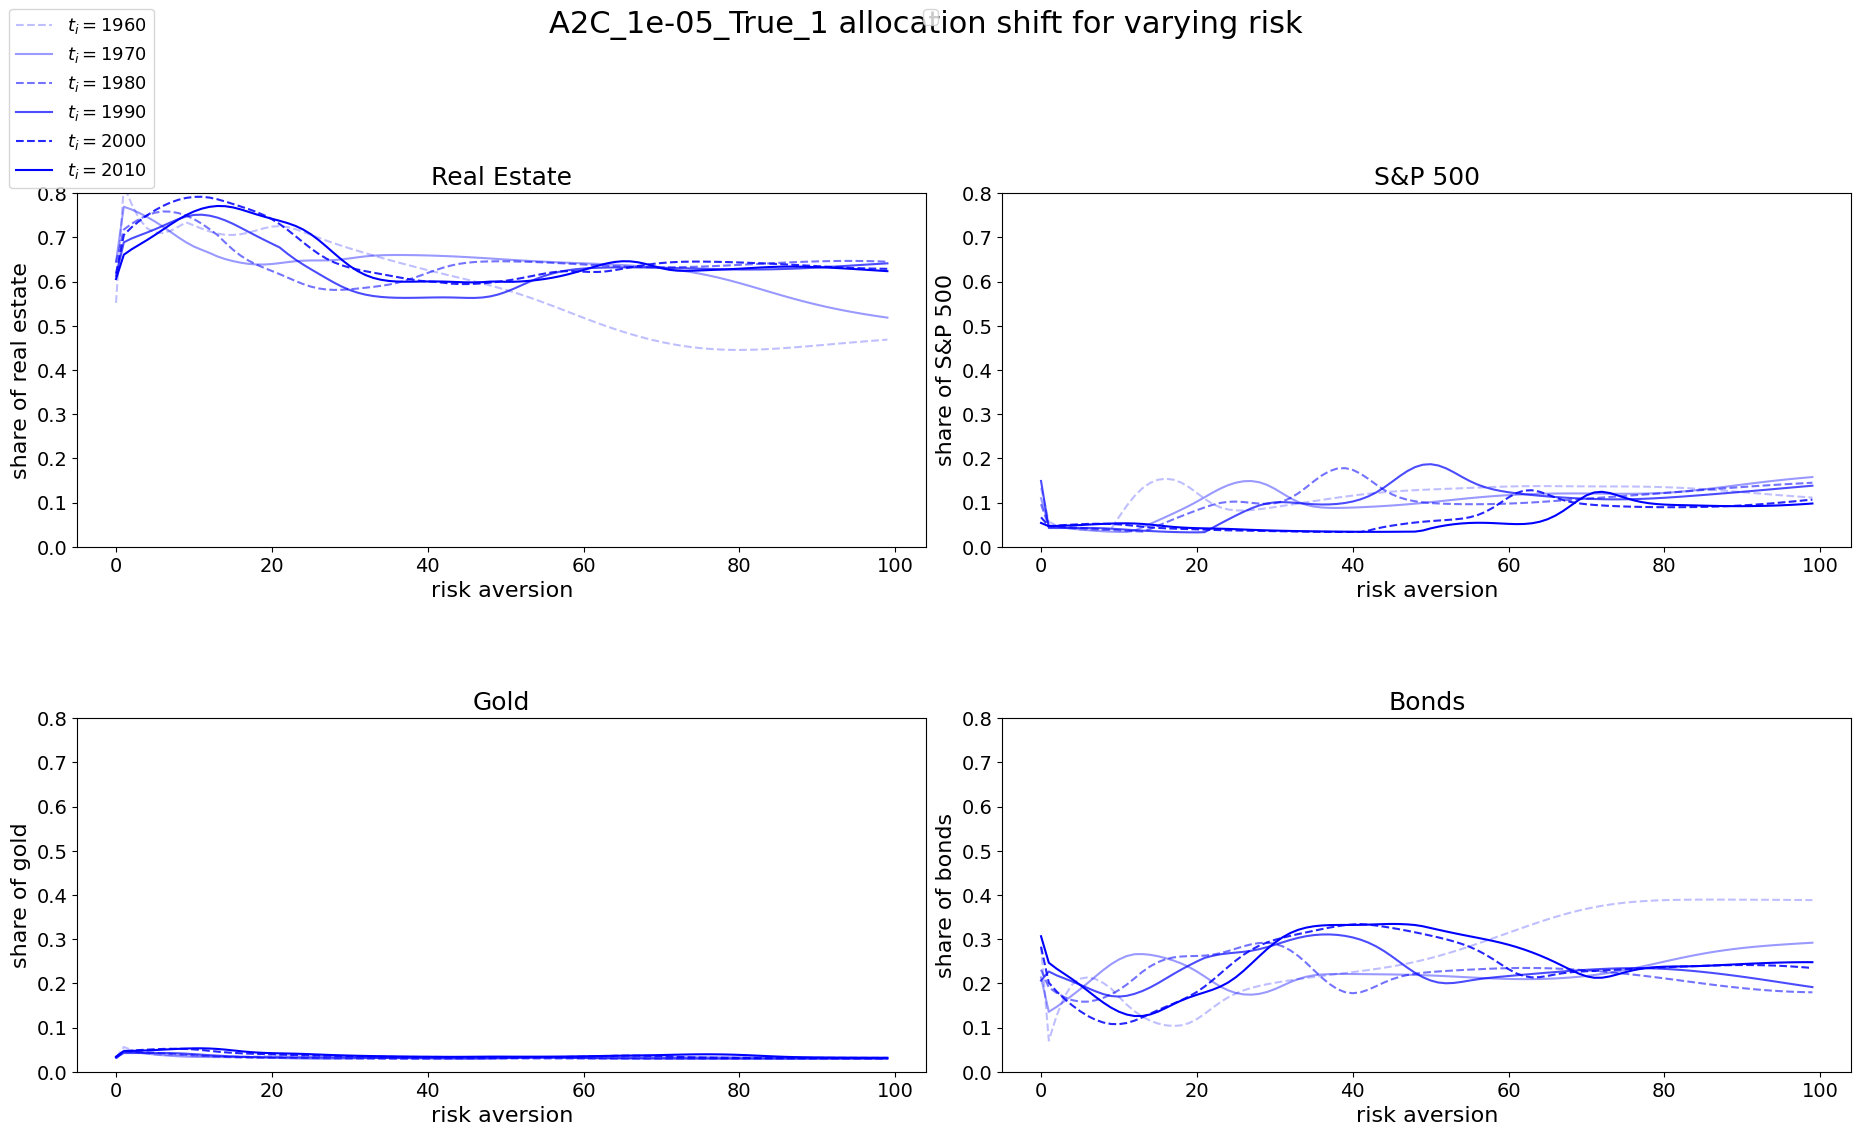

In [29]:
# plot model behavior (asset allocations shifts for varying risk aversion)

scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
mdls = ['SAC_1e-05_-_1','PPO1_1e-05_-_2','A2C_1e-05_True_1','SAC_1e-06_-_1','PPO1_0.01_-_1']
mdl=mdls[2]
for pit in [11, 20, 30, 40, 50, 57] :
		
		try:
		
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			for risk_preference in range(0,100):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference, 7), deterministic=True)
				actions_sum = action[0].sum()
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
				
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)

print(risk_actions_bonds)
fig = plt.figure()

ax1 = plt.subplot(2, 2, 1)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_real_estate[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	
	i += 1
ax1.set_title("Real Estate", fontsize=18)
ax1.set_xlabel("risk aversion", fontsize=16)
ax1.set_ylabel("share of real estate", fontsize=16)
ax1.set_ylim([0, .8])

ax2 = plt.subplot(2, 2, 2)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_sp500[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax2.set_title("S&P 500", fontsize=18)
ax2.set_xlabel("risk aversion", fontsize=16)
ax2.set_ylabel("share of S&P 500", fontsize=16)
ax2.set_ylim([0, .8])

ax3 = plt.subplot(2, 2, 3)
i = 0
lines = []
for pit in [11, 20, 30, 40, 50, 57]:
	l = plt.plot(range(0,100), risk_actions_gold[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	lines.append(l)
	i += 1
ax3.set_title("Gold", fontsize=18)
ax3.set_xlabel("risk aversion", fontsize=16)
ax3.set_ylabel("share of gold", fontsize=16)
ax3.set_ylim([0, .8])

ax4 = plt.subplot(2, 2, 4)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_bonds[i], color=(0,0,1, 0.25 + i * 0.15 ), label="$t_i=${}".format(1950 + 10 * ((pit+3) // 10)), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax4.set_title("Bonds", fontsize=18)
ax4.set_xlabel("risk aversion", fontsize=16)
ax4.set_ylabel("share of bonds", fontsize=16)
ax4.set_ylim([0, .8])
fig.tight_layout(pad=0.0)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('{} allocation shift for varying risk'.format(mdl), fontsize=22, y=1.12)
fig.legend(lines, [1,2,3,4,5,6], loc = 'upper center', ncol=5, labelspacing=0.)
fig.legend(loc="upper left", fontsize=13)
plt.savefig('f_{}_scatter_risk_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

[[0.39332747, 0.20980792, 0.21235694, 0.21475244, 0.21644378, 0.21764602, 0.2190266, 0.22010423, 0.22239995, 0.2255392, 0.23006992, 0.23566769, 0.24124798, 0.24716604, 0.25317863, 0.25815088, 0.26421237, 0.26918185, 0.27344862, 0.2776699, 0.28130195, 0.2848965, 0.28831106, 0.29158813, 0.29506788, 0.29842603, 0.30156484, 0.30491558, 0.30836293, 0.31187454, 0.3154085, 0.3189706, 0.32257628, 0.32630086, 0.32983723, 0.33317152, 0.33639652, 0.3394654, 0.34249613, 0.34555897, 0.34874785, 0.35198516, 0.3553543, 0.35870555, 0.36203614, 0.3652263, 0.3682245, 0.37128145, 0.37443826, 0.3774892, 0.3803269, 0.3829839, 0.3856225, 0.38827524, 0.39080888, 0.39332747, 0.39583063, 0.39830652, 0.40075484, 0.40317523, 0.40556335, 0.40792328, 0.41025496, 0.41256028, 0.41486675, 0.41717714, 0.41950998, 0.4218517, 0.42416587, 0.42645234, 0.42871127, 0.43093732, 0.43308893, 0.43520117, 0.43728757, 0.43935835, 0.4413967, 0.44335815, 0.4452953, 0.4472078, 0.44909585, 0.45095953, 0.45279872, 0.4546137, 0.4564043

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f18500e3ba8>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f18500ba048>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f185012ff60>] instances.
A proxy artist may be used instead.
See

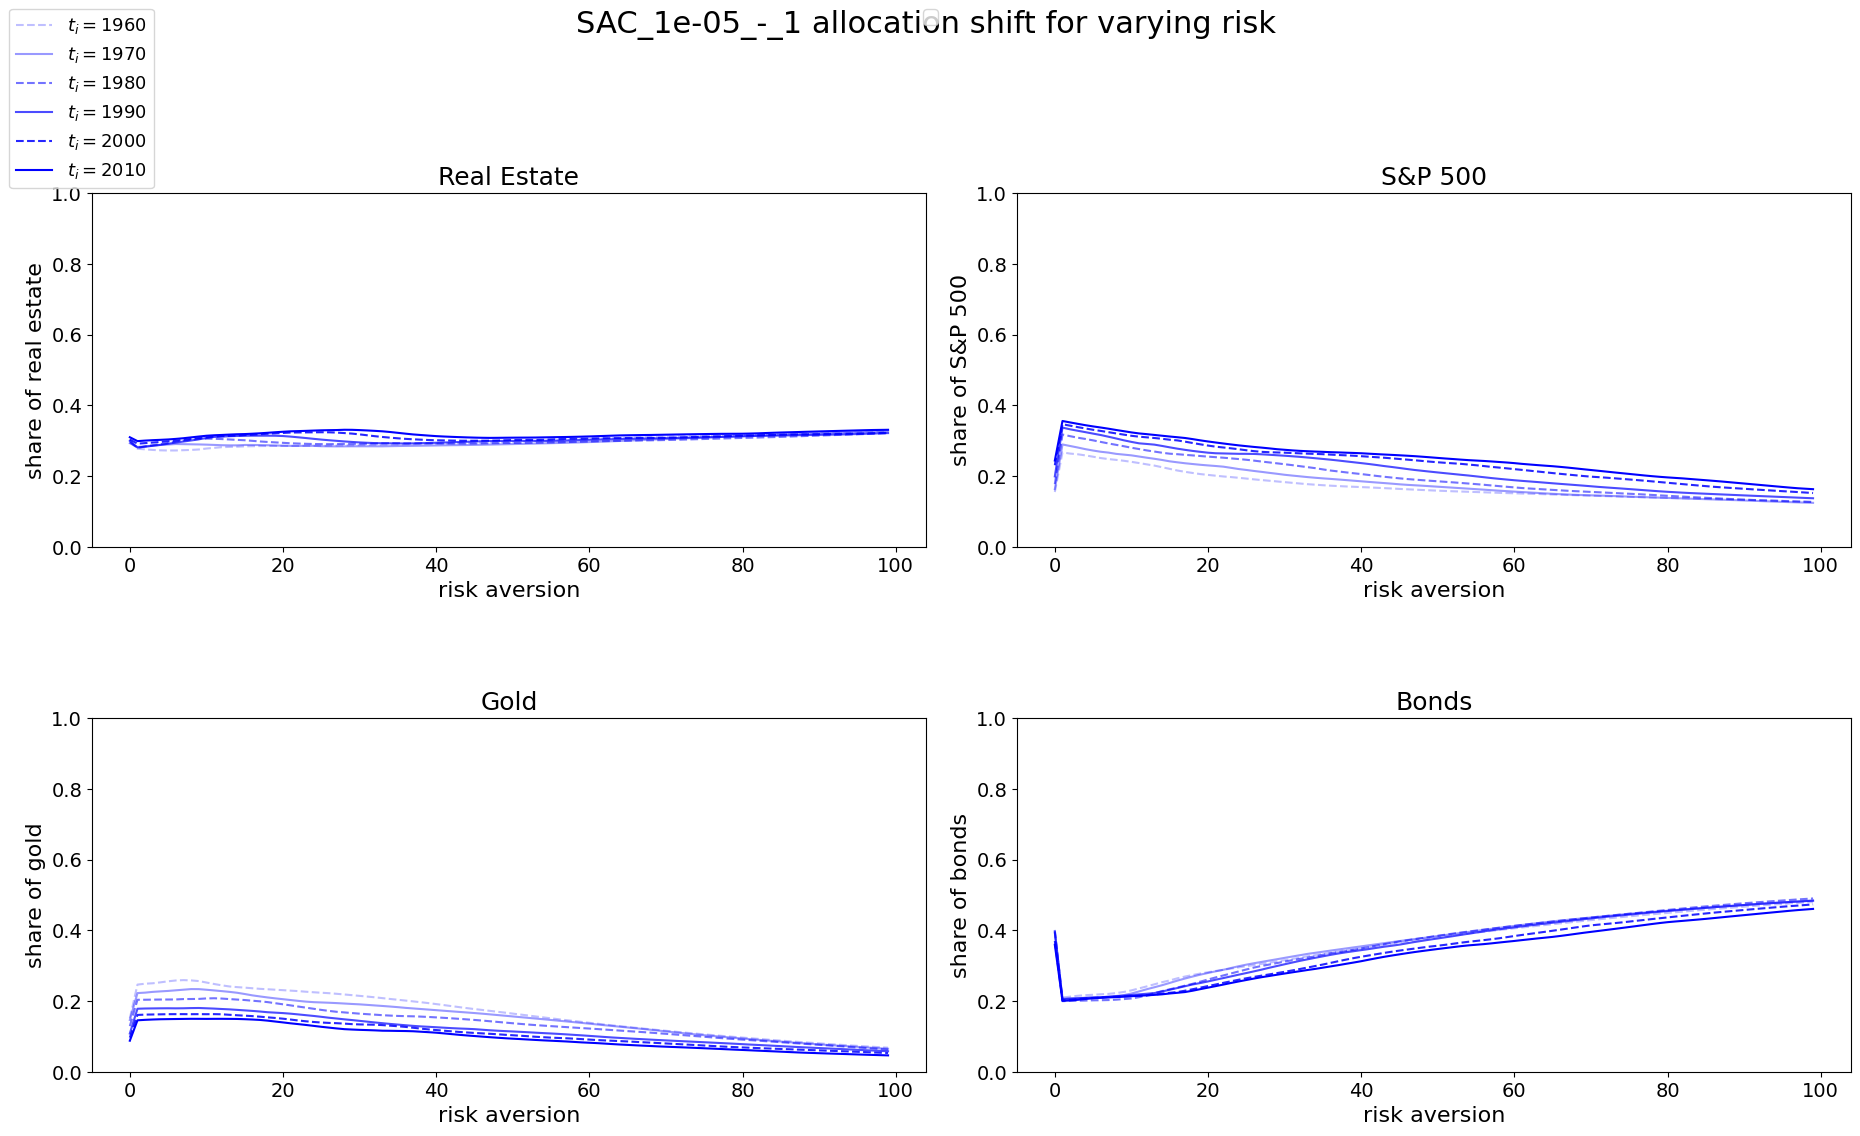

In [30]:
# outlier analysis
scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
mdls = ['SAC_1e-05_-_1','PPO1_1e-05_-_2','A2C_1e-05_True_1','SAC_1e-06_-_1','PPO1_0.01_-_1']
mdl=mdls[0]
for pit in [11, 20, 30, 40, 50, 57] :
		
		try:
		
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			for risk_preference in range(0,100):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference, 7), deterministic=True)
				actions_sum = action[0].sum()
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
		
		
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)

print(risk_actions_bonds)
fig = plt.figure()

ax1 = plt.subplot(2, 2, 1)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_real_estate[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	
	i += 1
ax1.set_title("Real Estate", fontsize=18)
ax1.set_xlabel("risk aversion", fontsize=16)
ax1.set_ylabel("share of real estate", fontsize=16)
ax1.set_ylim([0, 1])

ax2 = plt.subplot(2, 2, 2)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_sp500[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax2.set_title("S&P 500", fontsize=18)
ax2.set_xlabel("risk aversion", fontsize=16)
ax2.set_ylabel("share of S&P 500", fontsize=16)
ax2.set_ylim([0, 1])

ax3 = plt.subplot(2, 2, 3)
i = 0
lines = []
for pit in [11, 20, 30, 40, 50, 57]:
	l = plt.plot(range(0,100), risk_actions_gold[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	lines.append(l)
	i += 1
ax3.set_title("Gold", fontsize=18)
ax3.set_xlabel("risk aversion", fontsize=16)
ax3.set_ylabel("share of gold", fontsize=16)
ax3.set_ylim([0, 1])

ax4 = plt.subplot(2, 2, 4)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_bonds[i], color=(0,0,1, 0.25 + i * 0.15 ), label="$t_i=${}".format(1950 + 10 * ((pit+3) // 10)), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax4.set_title("Bonds", fontsize=18)
ax4.set_xlabel("risk aversion", fontsize=16)
ax4.set_ylabel("share of bonds", fontsize=16)
ax4.set_ylim([0, 1])
fig.tight_layout(pad=0.0)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('{} allocation shift for varying risk'.format(mdl), fontsize=22, y=1.12)
fig.legend(lines, [1,2,3,4,5,6], loc = 'upper center', ncol=5, labelspacing=0.)
fig.legend(loc="upper left", fontsize=13)
plt.savefig('f_{}_scatter_risk_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

[[0.2709026, 0.26661363, 0.25705528, 0.24013907, 0.21563917, 0.18846212, 0.16601318, 0.1514142, 0.14308026, 0.13833554, 0.13524035, 0.1326787, 0.13003865, 0.1269573, 0.12315536], [0.21194227, 0.21597753, 0.21772715, 0.21607937, 0.2090501, 0.19348618, 0.16660705, 0.1308424, 0.095392175, 0.06776819, 0.04792892, 0.04516954, 0.044671655, 0.043742035, 0.04260046], [0.23324431, 0.22947317, 0.22550823, 0.2202981, 0.21172534, 0.19623473, 0.16921933, 0.12749048, 0.07352066, 0.036244318, 0.036930244, 0.037600536, 0.038132306, 0.03849733, 0.038694046], [0.2583617, 0.22958103, 0.20636861, 0.1900109, 0.17925937, 0.17246869, 0.16812555, 0.16467565, 0.16022235, 0.15250692, 0.1401946, 0.12597866, 0.11669184, 0.11664395, 0.12416622], [0.3258595, 0.31715265, 0.30786422, 0.29914156, 0.29145595, 0.28467083, 0.27835965, 0.27212456, 0.26579076, 0.25937957, 0.25281549, 0.24553287, 0.23647027, 0.22526139, 0.21429813], [0.33709103, 0.3328993, 0.32509017, 0.3158179, 0.30707175, 0.29949427, 0.29314393, 0.2877248

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f18481469b0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f1848191e80>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f1848146f60>] instances.
A proxy artist may be used instead.
See

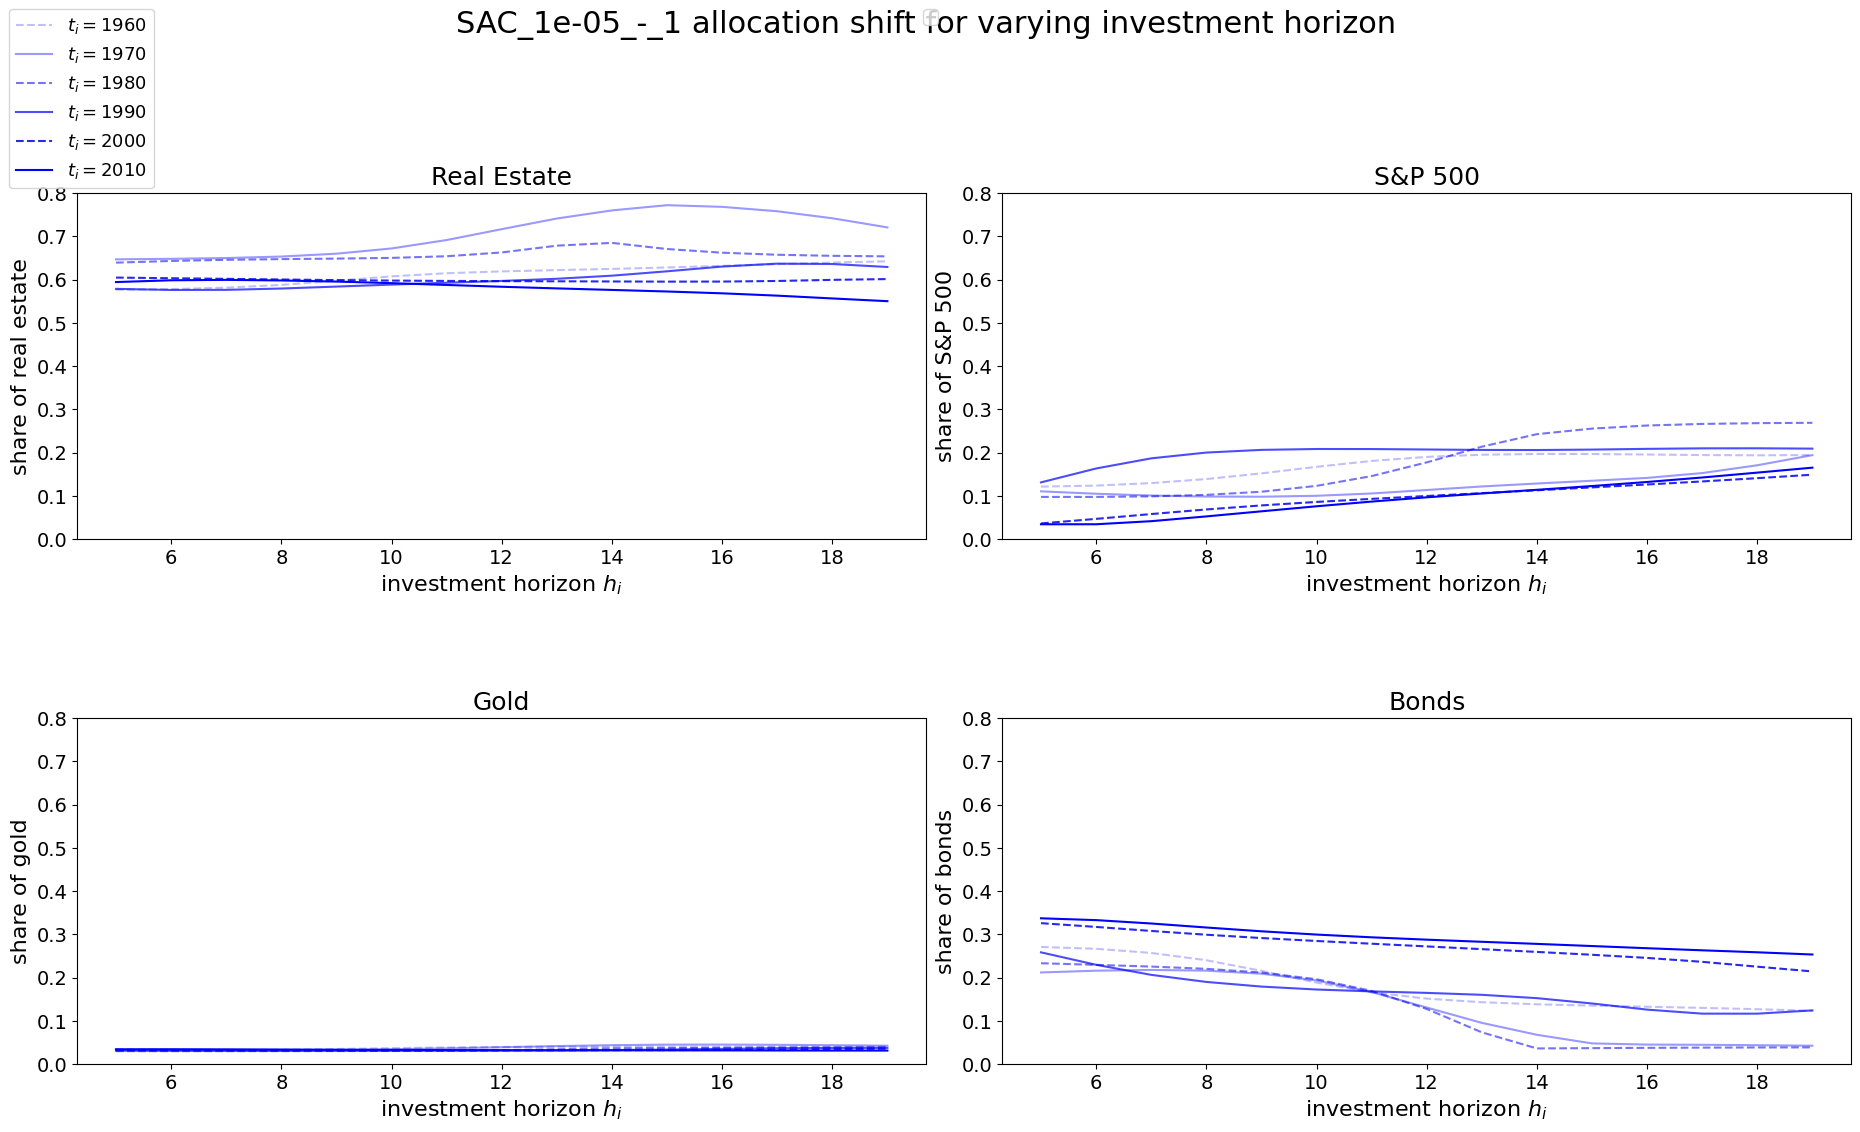

In [32]:
# plot agent behavior

scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
mdls = ['SAC_1e-05_-_1','PPO1_1e-05_-_2','A2C_1e-05_True_1','SAC_1e-06_-_1']
mdl=mdls[2]
for pit in [11, 20, 30, 40, 50, 57] :
		
		try:
			
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			for risk_preference in range(5,20):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
				
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference=50, horizon_preference=risk_preference), deterministic=True)
				
				actions_sum = action[0].sum()
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
				
		
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)

print(risk_actions_bonds)
fig = plt.figure()

ax1 = plt.subplot(2, 2, 1)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(5,20), risk_actions_real_estate[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	
	i += 1
ax1.set_title("Real Estate", fontsize=18)
ax1.set_xlabel("investment horizon $h_i$", fontsize=16)
ax1.set_ylabel("share of real estate", fontsize=16)
ax1.set_ylim([0, .8])

ax2 = plt.subplot(2, 2, 2)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(5,20), risk_actions_sp500[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax2.set_title("S&P 500", fontsize=18)
ax2.set_xlabel("investment horizon $h_i$", fontsize=16)
ax2.set_ylabel("share of S&P 500", fontsize=16)
ax2.set_ylim([0, .8])

ax3 = plt.subplot(2, 2, 3)
i = 0
lines = []
for pit in [11, 20, 30, 40, 50, 57]:
	l = plt.plot(range(5,20), risk_actions_gold[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	lines.append(l)
	i += 1
ax3.set_title("Gold", fontsize=18)
ax3.set_xlabel("investment horizon $h_i$", fontsize=16)
ax3.set_ylabel("share of gold", fontsize=16)
ax3.set_ylim([0, .8])

ax4 = plt.subplot(2, 2, 4)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(5,20), risk_actions_bonds[i], color=(0,0,1, 0.25 + i * 0.15 ), label="$t_i=${}".format(1950 + 10 * ((pit+3) // 10)), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax4.set_title("Bonds", fontsize=18)
ax4.set_xlabel("investment horizon $h_i$", fontsize=16)
ax4.set_ylabel("share of bonds", fontsize=16)
ax4.set_ylim([0, .8])
fig.tight_layout(pad=0.0)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('SAC_1e-05_-_1 allocation shift for varying investment horizon'.format(mdl), fontsize=22, y=1.12)
fig.legend(lines, [1,2,3,4,5,6], loc = 'upper center', ncol=5, labelspacing=0.)
fig.legend(loc="upper left", fontsize=13)
plt.savefig('f_SAC_1e-05_-_1_scatter_horizon_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

[[0.2709026, 0.26661363, 0.25705528, 0.24013907, 0.21563917, 0.18846212, 0.16601318, 0.1514142, 0.14308026, 0.13833554, 0.13524035, 0.1326787, 0.13003865, 0.1269573, 0.12315536], [0.21194227, 0.21597753, 0.21772715, 0.21607937, 0.2090501, 0.19348618, 0.16660705, 0.1308424, 0.095392175, 0.06776819, 0.04792892, 0.04516954, 0.044671655, 0.043742035, 0.04260046], [0.23324431, 0.22947317, 0.22550823, 0.2202981, 0.21172534, 0.19623473, 0.16921933, 0.12749048, 0.07352066, 0.036244318, 0.036930244, 0.037600536, 0.038132306, 0.03849733, 0.038694046], [0.2583617, 0.22958103, 0.20636861, 0.1900109, 0.17925937, 0.17246869, 0.16812555, 0.16467565, 0.16022235, 0.15250692, 0.1401946, 0.12597866, 0.11669184, 0.11664395, 0.12416622], [0.3258595, 0.31715265, 0.30786422, 0.29914156, 0.29145595, 0.28467083, 0.27835965, 0.27212456, 0.26579076, 0.25937957, 0.25281549, 0.24553287, 0.23647027, 0.22526139, 0.21429813], [0.33709103, 0.3328993, 0.32509017, 0.3158179, 0.30707175, 0.29949427, 0.29314393, 0.2877248

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f18481469b0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f1848191e80>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f1848146f60>] instances.
A proxy artist may be used instead.
See

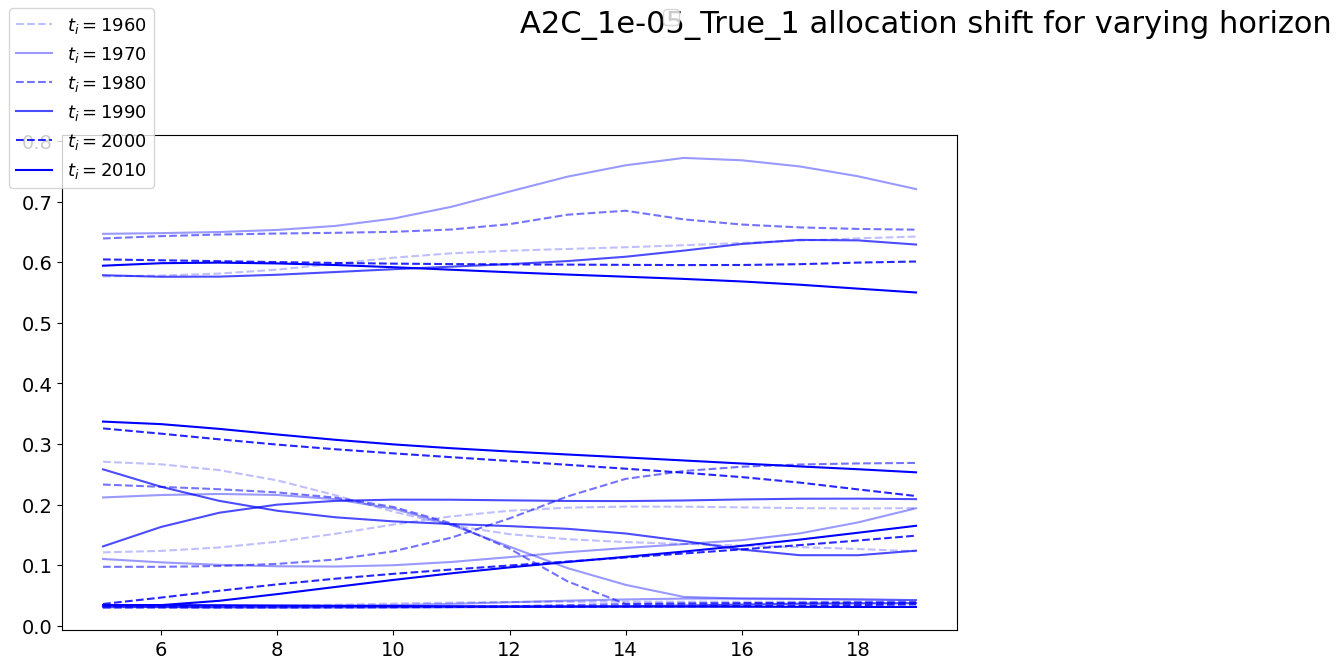

In [33]:
# plot agent behavior

scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
mdls = ['SAC_1e-05_-_1','PPO1_1e-05_-_2','A2C_1e-05_True_1','SAC_1e-06_-_1']
mdl=mdls[2]
for pit in [11, 20, 30, 40, 50, 57] :
		
		try:
			
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			for risk_preference in range(5,20):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference=50, horizon_preference=risk_preference), deterministic=True)
				actions_sum = action[0].sum()
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
		
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)

print(risk_actions_bonds)
fig = plt.figure()

ax1 = plt.subplot(2, 2, 1)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(5,20), risk_actions_real_estate[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))

	plt.plot(range(5,20), risk_actions_sp500[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))

	plt.plot(range(5,20), risk_actions_gold[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))

	plt.plot(range(5,20), risk_actions_bonds[i], color=(0,0,1, 0.25 + i * 0.15 ), label="$t_i=${}".format(1950 + 10 * ((pit+3) // 10)), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax4.set_title("Bonds", fontsize=18)
ax4.set_xlabel("risk aversion", fontsize=16)
ax4.set_ylabel("share of bonds", fontsize=16)
ax4.set_ylim([0, .6])
fig.tight_layout(pad=0.0)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('{} allocation shift for varying horizon'.format(mdl), fontsize=22, y=1.12)
fig.legend(lines, [1,2,3,4,5,6], loc = 'upper center', ncol=5, labelspacing=0.)
fig.legend(loc="upper left", fontsize=13)
plt.savefig('f_{}_scatter_horizon_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

In [35]:
# FINE TUNING FOR SAC
# Training Environment
env = CustomEnv(data, rebalancing=False)
eval_env = CustomEnv(data, rebalancing=False)
# Evaluation Callback (should it be on saparate environment? https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
eval_callback = EvalCallback(eval_env, eval_freq=200, callback_after_eval=stop_train_callback, verbose=0)


env.get_current_observation()

models = {

	"SAC":SAC,

	
	}
fine_scores = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
learning_rates = [1e-7]
batch_sizes = [1]
total_timesteps = 2500
performance_data_fine = {"agent": [], "learning rate":[], "batch size": [], "reward":[]}
for model, learning_rate, batch_size, rebalancing in product(models, learning_rates, batch_sizes, [False]):
	if model == "SAC":
		

		env = CustomEnv(data, rebalancing=rebalancing, risk_enforcement=3)
		eval_env = CustomEnv(data, rebalancing=rebalancing, risk_enforcement=3)
		stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
		eval_callback = EvalCallback(eval_env, eval_freq=200, callback_after_eval=stop_train_callback, verbose=0)
	
		print(model)
		n_actions = env.action_space.shape[-1]
		action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
		m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
		m.learn(total_timesteps=total_timesteps, callback=eval_callback)
		key = "{}_{}_-_{}_{}".format(model,str(learning_rate), str(batch_size), str(rebalancing))
		fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m, rebalancing=rebalancing)
		print("{} score is {}".format(key, fine_scores[key]))
		performance_data_fine["agent"].append(model)
		performance_data_fine["learning rate"].append(learning_rate)
		performance_data_fine["batch size"].append(batch_size)
		
		performance_data_fine["reward"].append(round(fine_scores[key],2))
		
		models_1[key] = m


	
vals = [fine_scores[s] for s in fine_scores.keys()]
print(sorted(zip(vals, fine_scores.keys()), reverse=True))



SAC


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/gym/core.py:269: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:180: DeprecationWarning: The truth v

local variable 'score' referenced before assignment
SAC_1e-07_-_1_False score is 904.7971531015746
[(904.7971531015746, 'SAC_1e-07_-_1_False')]


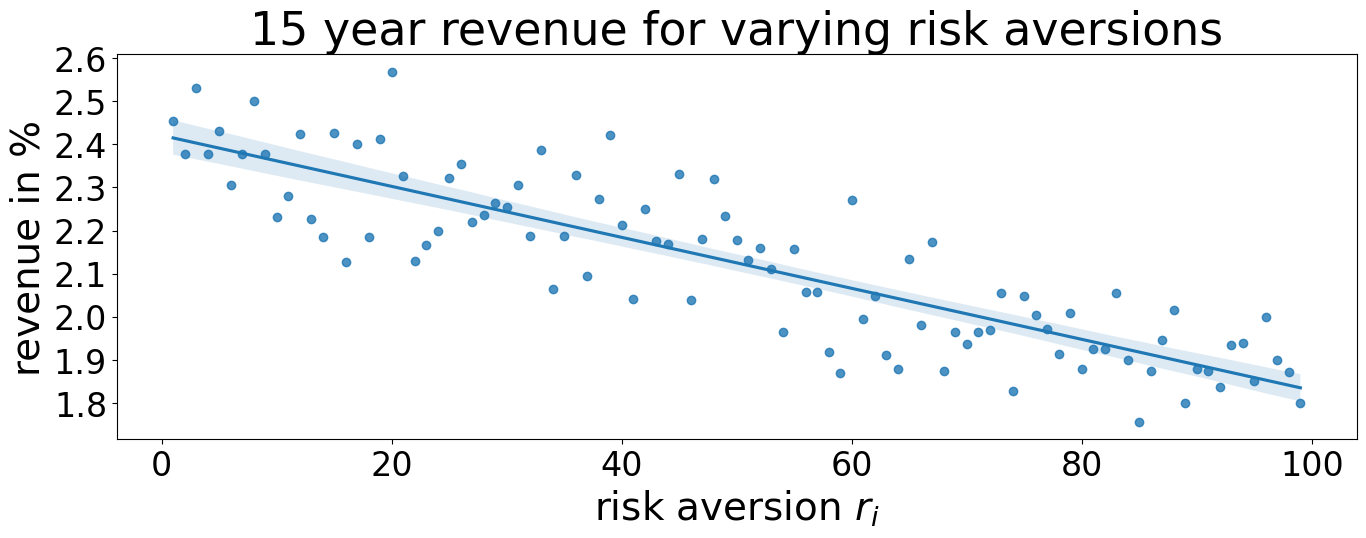

In [36]:
# plot risk return behavior for SAC
from statistics import mean
horizon=15
revs = []
for i in range(1,100):
    avg = []
    for t in range(11, 60):
        avg.append(env.calculate_revenue(models_1["SAC_1e-07_-_1_False"].predict(env.get_current_observation(t, i, horizon))[0]))
    
    revs.append(mean(avg)-1)
revs
frm = pd.DataFrame({"risk aversion": range(1,100), "revenue in %": revs})
sns.regplot(x="risk aversion", y="revenue in %", data=frm, label="")
plt.title("{} year revenue for varying risk aversions".format(horizon), fontsize=33)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.xlabel("risk aversion $r_i$", fontsize=28)
plt.ylabel("revenue in %", fontsize=28)
plt.savefig('f_{}_year_revenue_SAC_1e-7_1.pdf'.format(horizon), bbox_inches='tight')


In [38]:
perf_data = pd.DataFrame(performance_data_fine, ).sort_values("reward", ascending=False).reset_index().drop("index",axis=1)
perf_data.index = np.arange(1, len(perf_data) + 1)
perf_data['reward'].astype('str')

pd.options.display.float_format = '{:12.0e}'.format

pd.set_option('display.float_format', lambda x: '%.0e' % x if (x < 1 and x > 0) else '%.2f' % x)
NoEscape(perf_data.to_latex())

NoEscape(\begin{tabular}{llrrr}
\toprule
{} & agent &  learning rate &  batch size &  reward \\
\midrule
1 &   SAC &          1e-07 &           1 &  904.80 \\
\bottomrule
\end{tabular}
)

In [39]:
# test if benchmark stayed constant
fine_scores["Benchmark"] = 0
revenues["Benchmark"] = 0
env = CustomEnv(data, rebalancing=False)
for i in val_data.iterrows():
		env.set_current_observation = i[1].values
		try:
			
			env.current_point_in_time = i[1].values[1]
			env.risk_preference=i[1].values[2]
			env.horizon_preference=i[1].values[3]
			if i[1].values[2] <= lower_risk_bound:
			
				fine_scores["Benchmark"] += env._calculate_reward(np.array(benchmark_conservative))
			elif i[1].values[2] >= upper_risk_bound:
				fine_scores["Benchmark"] += env._calculate_reward(np.array(benchmark_aggresive))
			
			else:
				fine_scores["Benchmark"] += env._calculate_reward(benchmark)
			
		except:
			fine_scores["Benchmark"] = 0
			revenues["Benchmark"] = 0

print("Benchmark score is {}".format(fine_scores["Benchmark"]))


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:180: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Benchmark score is 161.48745323524201


[(904.7971531015746, 'SAC_1e-07_-_1_False'), (161.48745323524201, 'Benchmark')]


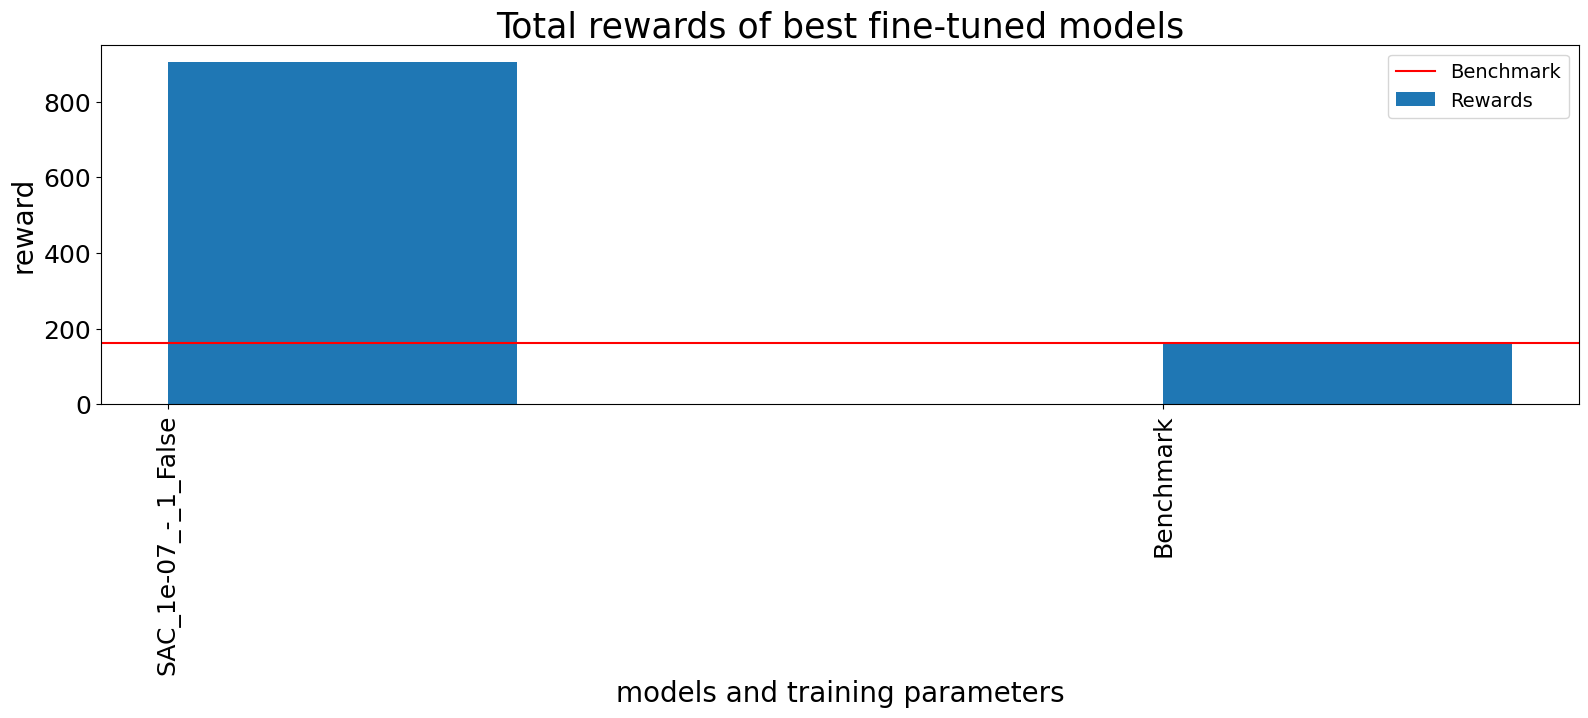

In [40]:
# plot results of fine tuning

vals = [(fine_scores[s] )  for s in fine_scores.keys()]
print(sorted(zip(vals, fine_scores.keys()), reverse=True))



plt.rcParams["figure.figsize"] = (16,5)
fig2, ax1 = plt.subplots()
labels = [k for k in fine_scores]
x = np.arange(len(labels))

b3 = ax1.bar(x + 0.175, [fine_scores[k] for k in fine_scores], 0.35, label="Rewards")
ax1.set_xticks(x, labels)
ax1.set_title("Total rewards of best fine-tuned models", fontsize=25)

ax1.set_ylabel("reward", fontsize=20)
ax1.set_xlabel("models and training parameters", fontsize=20)
fig2.tight_layout()
plt.xticks(rotation='vertical', fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(y=fine_scores["Benchmark"], color='r', linestyle='-', label="Benchmark")
plt.legend()
plt.savefig('f_fine_tuning_SAC.pdf'.format(mdl), bbox_inches='tight')
plt.show()

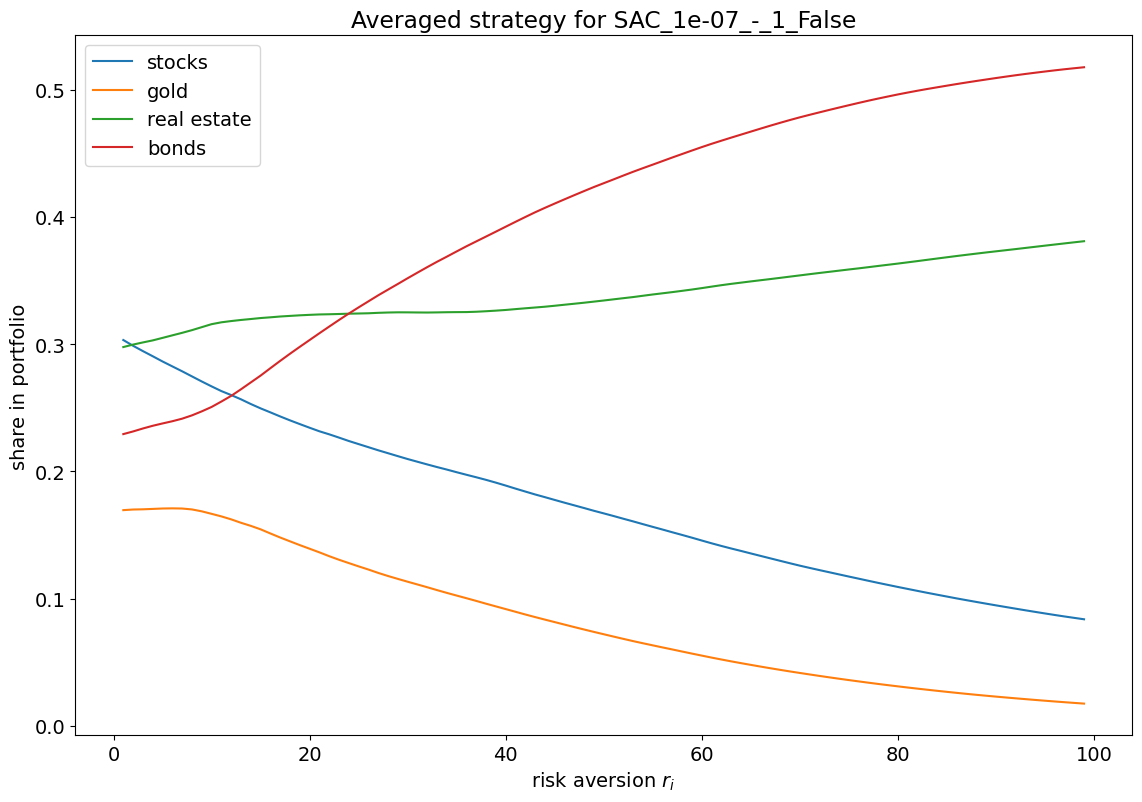

In [41]:
# plot averaged strategy
scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
mdls = ['SAC_1e-07_-_1_False',]
mdl=mdls[0]
plt.figure(figsize=(30,20), facecolor="white")
for pit in [11, 20, 30, 40, 50, 57] :
	
		try:
			
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			for risk_preference in range(1,100):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
			
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference, 7), deterministic=True)
				
				actions_sum = action[0].sum()
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
				
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)




ax1 = plt.subplot(2, 2, 1)
i = 0

stocks_avg = np.average(np.array([risk_actions_sp500[i] for i in range(0,6)]), axis=0)

plt.plot(range(1,100), stocks_avg,  label="stocks")
gold_avg = np.average(np.array([risk_actions_gold[i] for i in range(0,6)]), axis=0)

plt.plot(range(1,100), gold_avg,  label="gold")
real_avg = np.average(np.array([risk_actions_real_estate[i] for i in range(0,6)]), axis=0)

plt.plot(range(1,100), real_avg, label="real estate")





bonds_avg = np.average(np.array([risk_actions_bonds[i] for i in range(0,6)]), axis=0)

fig = plt.plot(range(1,100), bonds_avg,  label="bonds")

plt.xlabel("risk aversion $r_i$")
plt.ylabel("share in portfolio")
plt.legend()
plt.title("Averaged strategy for {}".format(mdl))
plt.savefig('f_{}_average_over_time_risk_dep_allocs.pdf'.format(mdl), bbox_inches='tight')
plt.show()		

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Legend does not support 'SAC' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


<Figure size 1600x500 with 0 Axes>

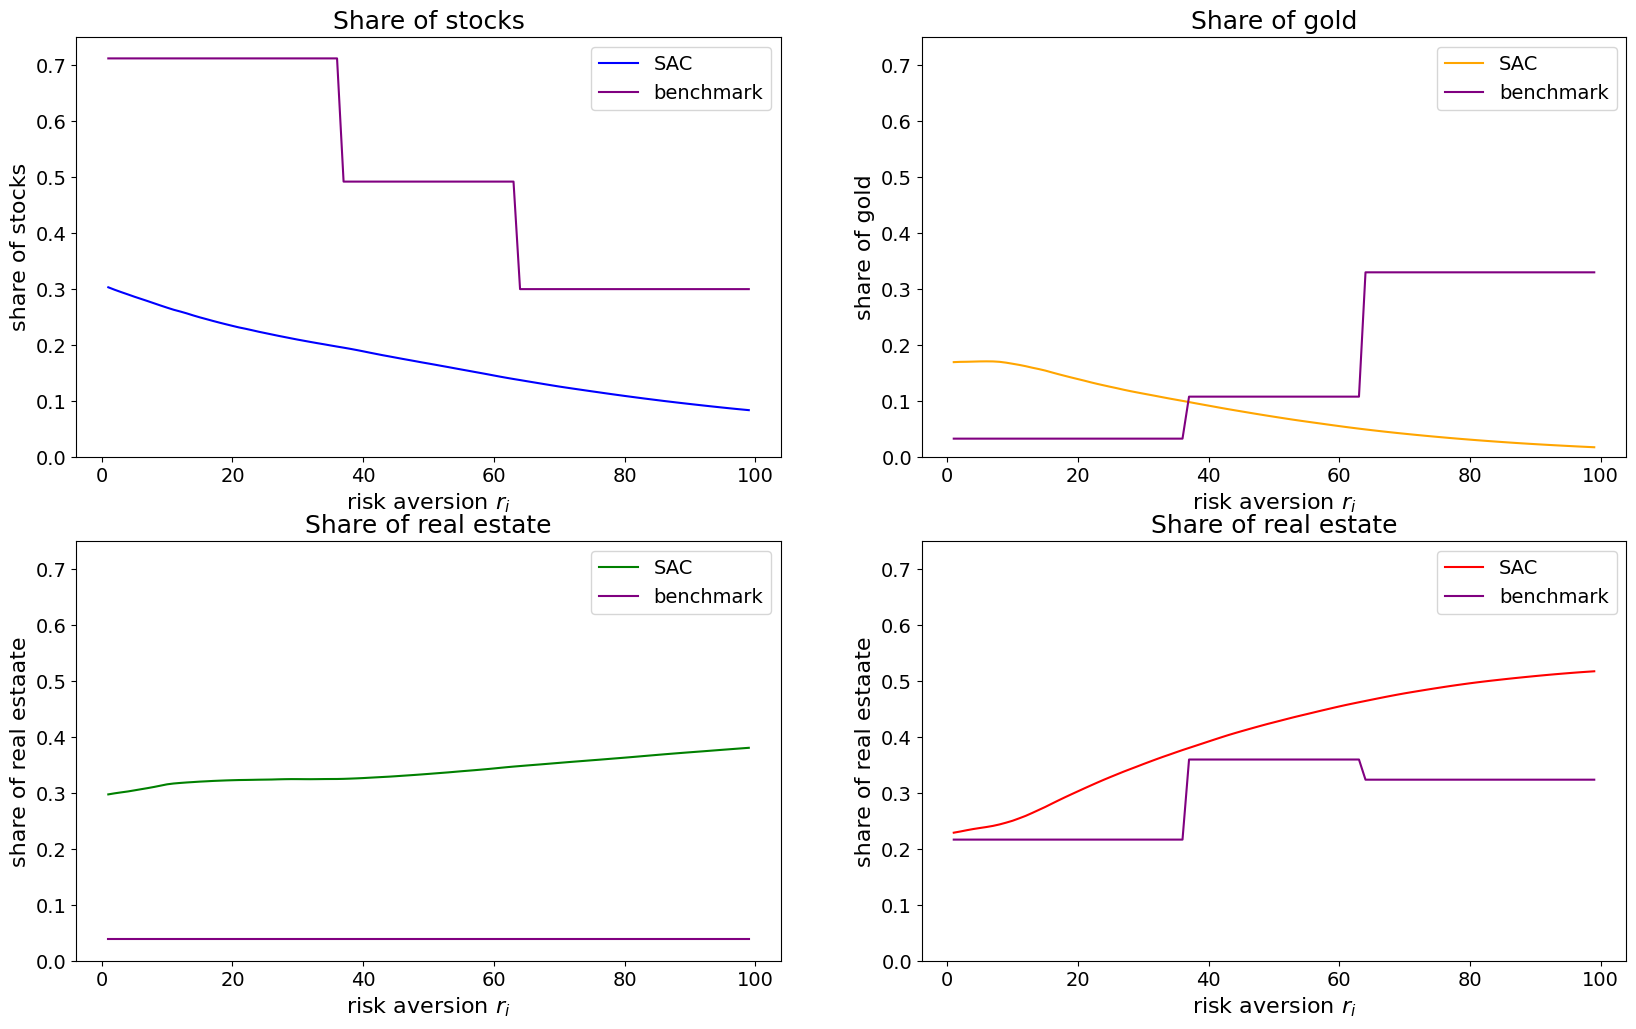

In [42]:
# plot benchmark comparison
fig = plt.figure()
plt.figure(figsize=(20,12), facecolor="white")
ax1 = plt.subplot(2, 2, 1)

plt.plot(range(1,100), stocks_avg, color="blue",  label="SAC")
plt.plot(range(1,100), [.712 for x in range(1,37)] + [.492 for x in range(37,64)]+ [.30 for x in range(64,100)],  color="purple", label="benchmark")
plt.legend()	
ax1.set_title("Share of stocks", fontsize=18)
ax1.set_xlabel("risk aversion $r_i$", fontsize=16)
ax1.set_ylabel("share of stocks", fontsize=16)
ax1.set_ylim([0, .75])

ax2 = plt.subplot(2, 2, 2)
plt.plot(range(1,100), gold_avg,  label="SAC", color ="orange")
plt.plot(range(1,100), [.033 for x in range(1,37)] + [.108 for x in range(37,64)]+ [.33 for x in range(64,100)], color="purple",label="benchmark")
plt.legend()	
ax2.set_title("Share of gold", fontsize=18)
ax2.set_xlabel("risk aversion $r_i$", fontsize=16)
ax2.set_ylabel("share of gold", fontsize=16)
ax2.set_ylim([0, .75])

ax3 = plt.subplot(2, 2, 3)
plt.plot(range(1,100), real_avg, color="green",  label="SAC")
plt.plot(range(1,100), [.04 for x in range(1,37)] + [.04 for x in range(37,64)]+ [.04 for x in range(64,100)],  color="purple", label="benchmark")
plt.legend()	
ax3.set_title("Share of real estate", fontsize=18)
ax3.set_xlabel("risk aversion $r_i$", fontsize=16)
ax3.set_ylabel("share of real estaate", fontsize=16)
ax3.set_ylim([0, .75])

ax4 = plt.subplot(2, 2, 4)
plt.plot(range(1,100), bonds_avg, color="red", label="SAC")
plt.plot(range(1,100), [.217 for x in range(1,37)] + [.36 for x in range(37,64)]+ [.324 for x in range(64,100)], color="purple", label="benchmark")
plt.legend()	
ax4.set_title("Share of real estate", fontsize=18)
ax4.set_xlabel("risk aversion $r_i$", fontsize=16)
ax4.set_ylabel("share of real estaate", fontsize=16)
ax4.set_ylim([0, .75])

fig.legend(["SAC"], [1,2,3,4,5,6], loc = 'upper center', ncol=5, labelspacing=0.)

plt.savefig('f_{}_comparison_benchmark_behavior.pdf'.format(mdl), bbox_inches='tight' )
plt.show()	


[[0.4917227, 0.22330199, 0.22666426, 0.22985837, 0.2322646, 0.23420602, 0.23656915, 0.23901923, 0.24244569, 0.24759144, 0.2535593, 0.26049918, 0.26752892, 0.27523905, 0.28284654, 0.2897421, 0.29727426, 0.30347613, 0.3092559, 0.3144905, 0.3192483, 0.3240303, 0.32862052, 0.3329355, 0.3373338, 0.341808, 0.34614134, 0.35052508, 0.35508984, 0.3596585, 0.36429763, 0.36896506, 0.37370533, 0.37841794, 0.3828684, 0.38715947, 0.39143747, 0.3954368, 0.39932603, 0.40316668, 0.4070813, 0.41098008, 0.4148048, 0.41846487, 0.42203638, 0.4254186, 0.4287437, 0.432022, 0.43540296, 0.43873307, 0.44170454, 0.4445725, 0.44736865, 0.45005172, 0.45263207, 0.4551881, 0.4576977, 0.46013838, 0.46252972, 0.4649243, 0.46726337, 0.46954498, 0.47177184, 0.47394222, 0.4760929, 0.4782327, 0.48034388, 0.4823696, 0.48434508, 0.48627084, 0.48814082, 0.48995498, 0.4917227, 0.49344382, 0.49515206, 0.49681714, 0.49843955, 0.50001997, 0.50155914, 0.5030578, 0.50451654, 0.5059363, 0.50727016, 0.50855875, 0.5098114, 0.51102847

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f18600b8320>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f19636d6780>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f18600b88d0>] instances.
A proxy artist may be used instead.
See

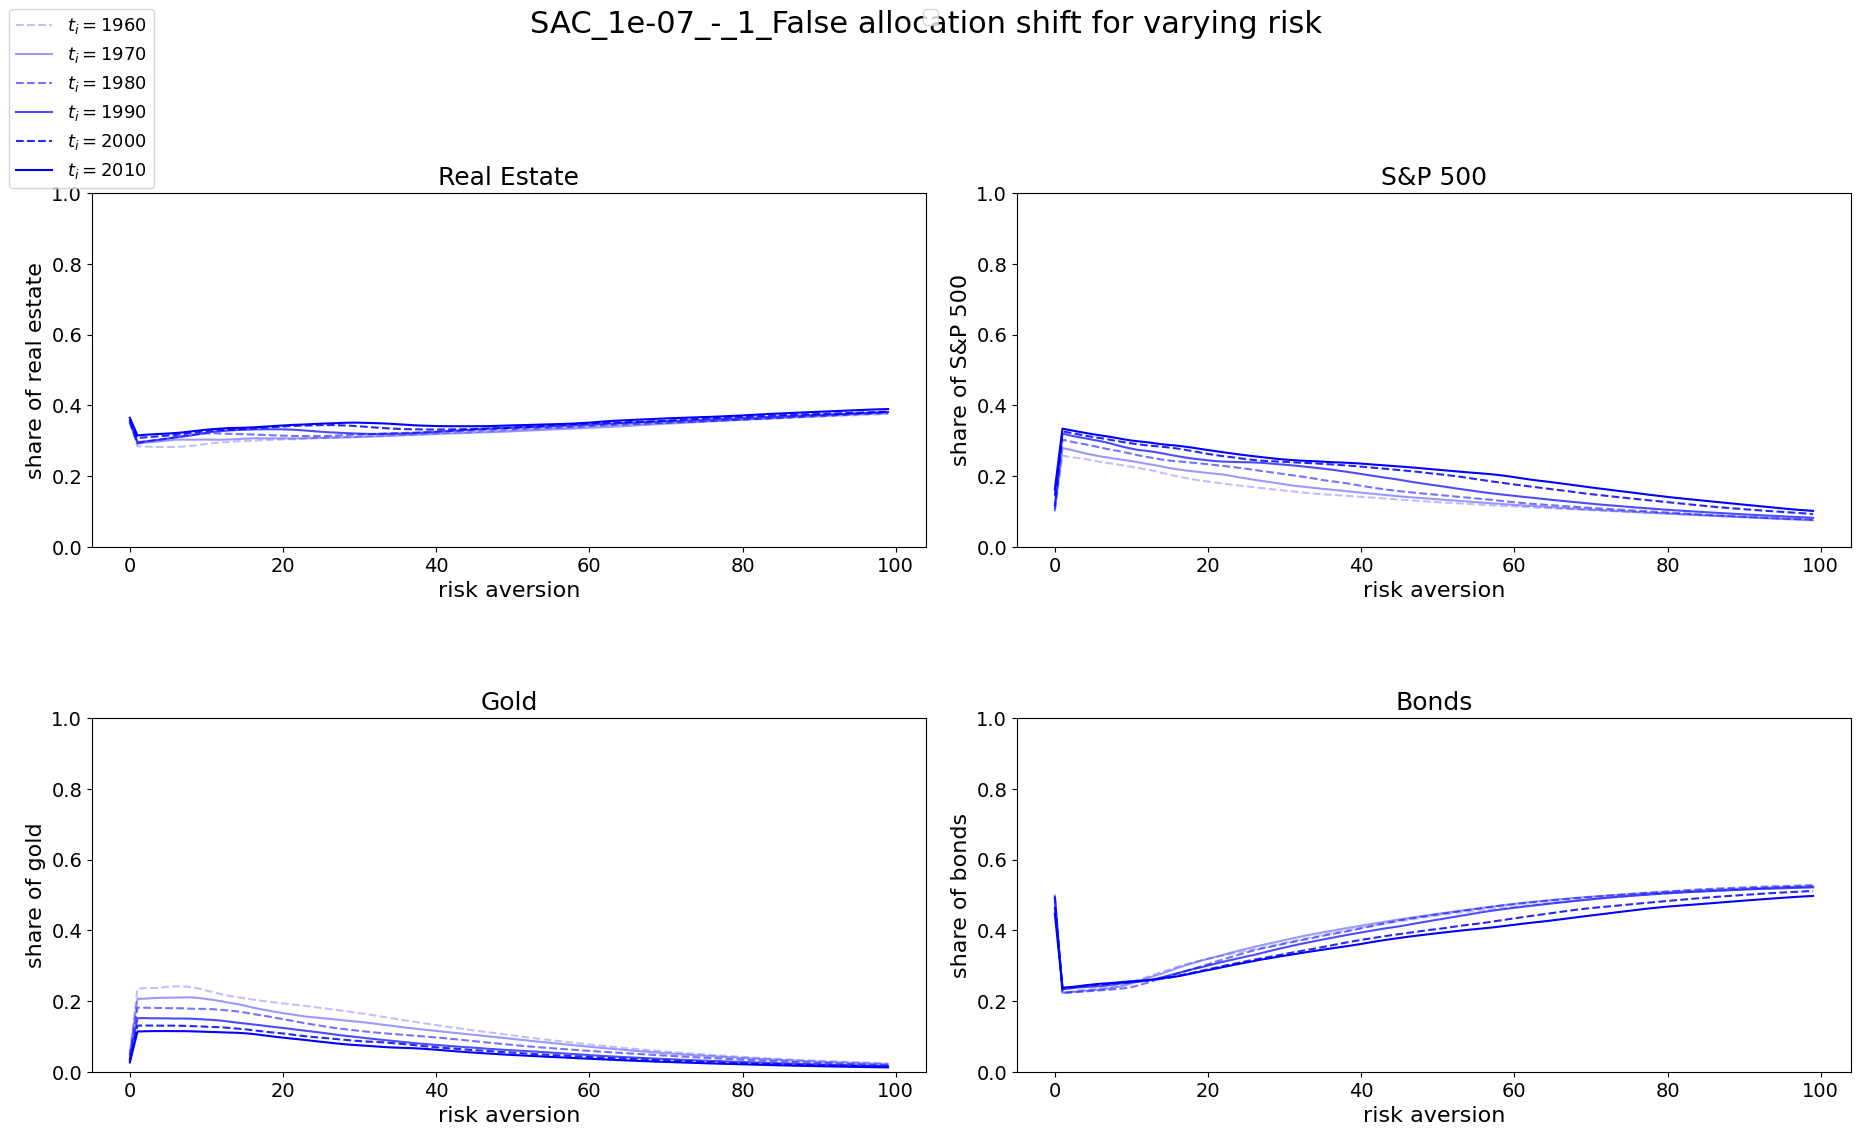

In [43]:
# analyze behavior of best SAC
scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
mdls = ['SAC_1e-07_-_1_False',]
mdl=mdls[0]
for pit in [11, 20, 30, 40, 50, 57] :
		
		try:
			
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			for risk_preference in range(0,100):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference, 7), deterministic=True)
				actions_sum = action[0].sum()
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
		
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)

print(risk_actions_bonds)
fig = plt.figure()

ax1 = plt.subplot(2, 2, 1)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_real_estate[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	
	i += 1
ax1.set_title("Real Estate", fontsize=18)
ax1.set_xlabel("risk aversion", fontsize=16)
ax1.set_ylabel("share of real estate", fontsize=16)
ax1.set_ylim([0, 1])

ax2 = plt.subplot(2, 2, 2)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_sp500[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax2.set_title("S&P 500", fontsize=18)
ax2.set_xlabel("risk aversion", fontsize=16)
ax2.set_ylabel("share of S&P 500", fontsize=16)
ax2.set_ylim([0, 1])

ax3 = plt.subplot(2, 2, 3)
i = 0
lines = []
for pit in [11, 20, 30, 40, 50, 57]:
	l = plt.plot(range(0,100), risk_actions_gold[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	lines.append(l)
	i += 1
ax3.set_title("Gold", fontsize=18)
ax3.set_xlabel("risk aversion", fontsize=16)
ax3.set_ylabel("share of gold", fontsize=16)
ax3.set_ylim([0, 1])

ax4 = plt.subplot(2, 2, 4)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_bonds[i], color=(0,0,1, 0.25 + i * 0.15 ), label="$t_i=${}".format(1950 + 10 * ((pit+3) // 10)), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax4.set_title("Bonds", fontsize=18)
ax4.set_xlabel("risk aversion", fontsize=16)
ax4.set_ylabel("share of bonds", fontsize=16)
ax4.set_ylim([0, 1])
fig.tight_layout(pad=0.0)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('{} allocation shift for varying risk'.format(mdl), fontsize=22, y=1.12)
fig.legend(lines, [1,2,3,4,5,6], loc = 'upper center', ncol=5, labelspacing=0.)
fig.legend(loc="upper left", fontsize=13)
plt.savefig('f_{}_scatter_risk_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

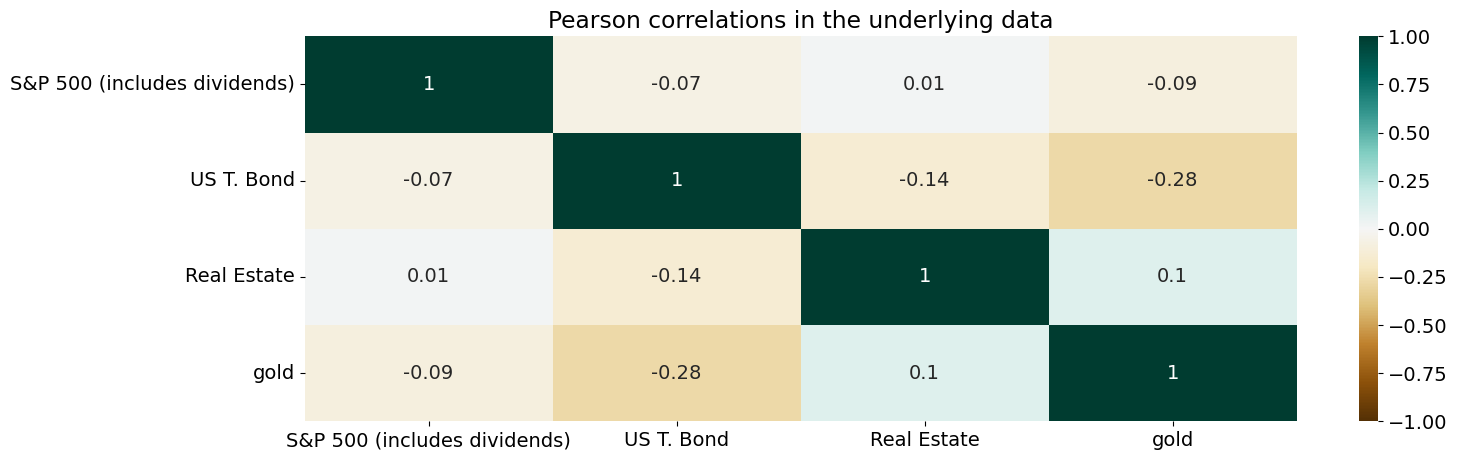

In [44]:
# plot pearson correlations between asset classes
sns.heatmap(data.drop("Year", axis=1).drop("Baa Corporate Bond", axis=1).drop("Inflation Rate", axis=1).corr().round(2), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title("Pearson correlations in the underlying data")
plt.savefig('f_pearon_correlations.pdf'.format(mdl), bbox_inches='tight')

In [45]:

# Training with fixed rebalancing boundary
env = CustomEnv(data, rebalancing=False)
eval_env = CustomEnv(data, rebalancing=False)
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
eval_callback = EvalCallback(eval_env, eval_freq=200, callback_after_eval=stop_train_callback, verbose=0)

env.get_current_observation()

models = {

	"SAC":SAC,
	
	
	}
fine_scores_reb = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
learning_rates = [1e-7]
batch_sizes = [1]
total_timesteps = 2500
performance_data_fixed = {"agent": [], "learning rate":[], "batch size": [], "rebalancing boundary":[], "reward":[]}
for model, learning_rate, batch_size, rebalancing in product(models, learning_rates, batch_sizes, [False, 0.2, 0.5, 0.7, 1]):
	if model == "SAC":

		risk_enforcement = 2
		env = CustomEnv(data, rebalancing=rebalancing, risk_enforcement=risk_enforcement)
		eval_env = CustomEnv(data, rebalancing=rebalancing, risk_enforcement=risk_enforcement)
		stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
		eval_callback = EvalCallback(eval_env, eval_freq=200, callback_after_eval=stop_train_callback, verbose=0)
	
		print(model)
		n_actions = env.action_space.shape[-1]
		action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
		m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
		m.learn(total_timesteps=total_timesteps, callback=eval_callback)
		key = "{}_{}_-_{}_{}".format(model,str(learning_rate), str(batch_size), str(rebalancing))
		fine_scores_reb[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m, rebalancing=rebalancing, risk_enforcement=risk_enforcement)
		print("{} score is {}".format(key, fine_scores_reb[key]))
		performance_data_fixed["agent"].append(model)
		performance_data_fixed["learning rate"].append(learning_rate)
		performance_data_fixed["batch size"].append(batch_size)
		performance_data_fixed["rebalancing boundary"].append(rebalancing)
		performance_data_fixed["reward"].append(round(fine_scores_reb[key],2))
		
		models_1[key] = m



SAC


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/gym/core.py:269: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:180: DeprecationWarning: The truth v

local variable 'score' referenced before assignment
SAC_1e-07_-_1_False score is 547.4775343615521
SAC
local variable 'score' referenced before assignment
SAC_1e-07_-_1_0.2 score is 594.8674507430452
SAC
local variable 'score' referenced before assignment
SAC_1e-07_-_1_0.5 score is 566.0348410288597
SAC
local variable 'score' referenced before assignment
SAC_1e-07_-_1_0.7 score is 538.344611713117
SAC
local variable 'score' referenced before assignment
SAC_1e-07_-_1_1 score is 517.6934378234023


In [46]:
# format number output
performance_data_fixed["reward"] = performance_data_fixed["reward"] - delta
perf_data_fixed = pd.DataFrame(performance_data_fixed, ).sort_values("reward", ascending=False).reset_index().drop("index",axis=1)
perf_data_fixed.index = np.arange(1, len(perf_data_fixed) + 1)
perf_data_fixed['reward'].astype('str')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(NoEscape(perf_data_fixed.to_latex()))
performance_data_fixed["learning rate"] = "$10{-7}$"
pd.reset_option('display.float_format')

NameError: name 'delta' is not defined

[(952.1840122303926, 'SAC_1e-07_-_1_0.2'), (923.351402516207, 'SAC_1e-07_-_1_0.5'), (904.7940958488995, 'SAC_1e-07_-_1_False'), (895.6611732004644, 'SAC_1e-07_-_1_0.7'), (875.0099993107497, 'SAC_1e-07_-_1_1')]


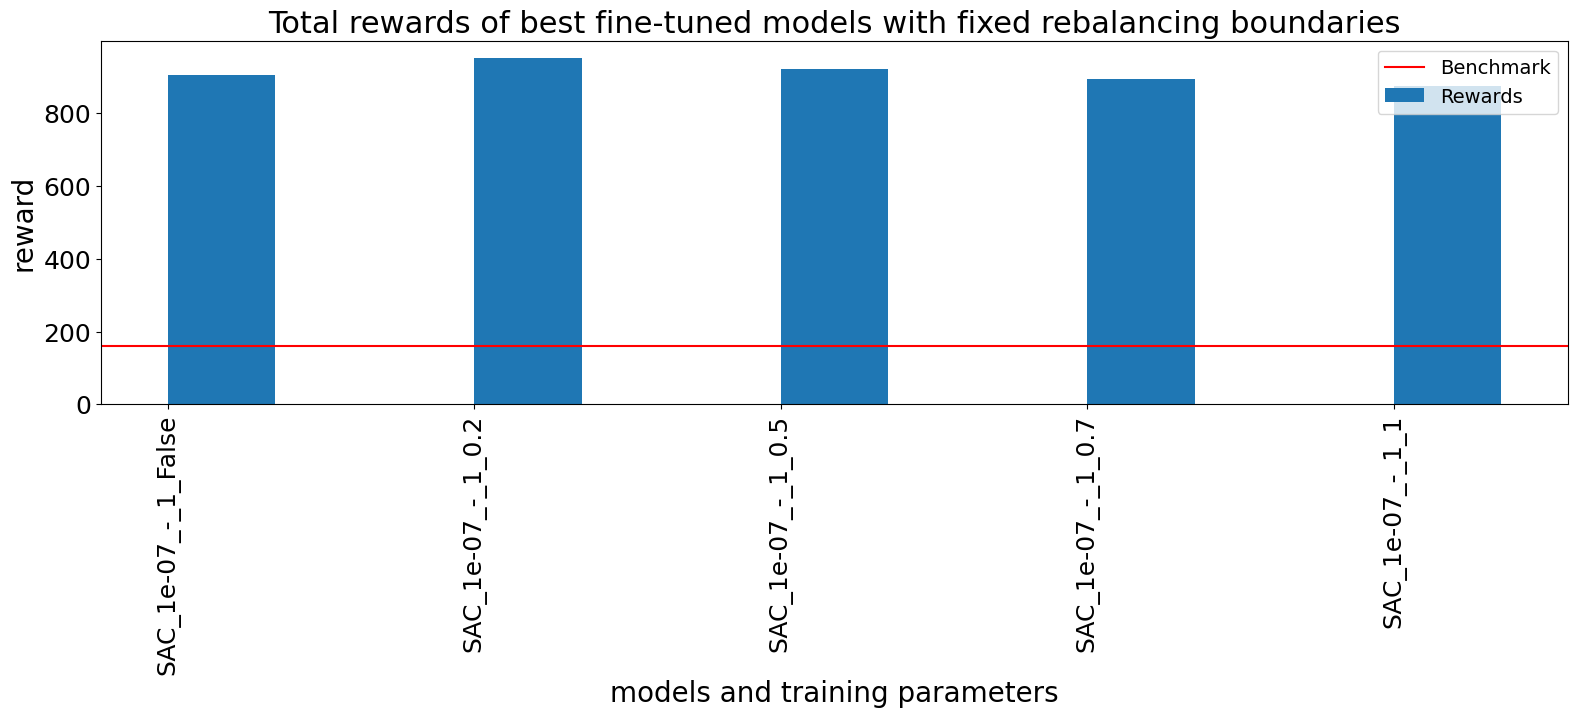

In [ ]:
max_fine_seach = fine_scores["SAC_1e-07_-_1_False"]
res_wo_reb_delta = fine_scores["SAC_1e-07_-_1_False"] - 857.4102939727567
max_reb_ = fine_scores_reb['SAC_1e-07_-_1_0.2']
delta = fine_scores["SAC_1e-07_-_1_False"] - fine_scores_reb['SAC_1e-07_-_1_0.2'] + res_wo_reb_delta
	
vals = [(fine_scores_reb[s] + delta)  for s in fine_scores_reb.keys()]
print(sorted(zip(vals, fine_scores_reb.keys()), reverse=True))



plt.rcParams["figure.figsize"] = (16,5)
fig2, ax1 = plt.subplots()
labels = [k for k in fine_scores_reb]
x = np.arange(len(labels))
#b1 = ax1.bar(x - 0.175 , [revenues[k] for k in revenues], 0.35, label="Revenues")
b3 = ax1.bar(x + 0.175, [fine_scores_reb[k] + delta for k in fine_scores_reb], 0.35, label="Rewards")
ax1.set_xticks(x, labels)
ax1.set_title("Total rewards of best fine-tuned models with fixed rebalancing boundaries", fontsize=22)
# ax1.bar_label(b1, padding=3)
# ax1.bar_label(b2, padding=3)
ax1.set_ylabel("reward", fontsize=20)
ax1.set_xlabel("models and training parameters", fontsize=20)
fig2.tight_layout()
plt.xticks(rotation='vertical', fontsize=18)
plt.rc('ytick',labelsize=18)
plt.axhline(y=fine_scores["Benchmark"], color='r', linestyle='-', label="Benchmark")
plt.legend()
plt.savefig('f_search_fixed_rebalancing.pdf', bbox_inches='tight' )
plt.show()

[[0.45519242, 0.2233024, 0.22666466, 0.22985879, 0.23226506, 0.23420651, 0.23656967, 0.23901977, 0.24244632, 0.24759205, 0.25355998, 0.26049998, 0.26752976, 0.27523994, 0.28284743, 0.28974313, 0.29727533, 0.3034773, 0.30925712, 0.31449178, 0.31924963, 0.3240317, 0.32862204, 0.3329371, 0.33733547, 0.34180978, 0.3461432, 0.35052696, 0.35509184, 0.3596606, 0.36429983, 0.36896738, 0.3737077, 0.3784204, 0.38287103, 0.38716218, 0.3914402, 0.3954397, 0.39932895, 0.40316972, 0.40708447, 0.4109833, 0.41480812, 0.41846824, 0.42203984, 0.42542213, 0.4287473, 0.43202573, 0.43540677, 0.43873698, 0.44170853, 0.44457662, 0.44737276, 0.4500559, 0.45263645, 0.45519242, 0.4577021, 0.4601429, 0.46253428, 0.46492898, 0.46726802, 0.46954978, 0.47177672, 0.4739471, 0.4760979, 0.4782377, 0.48034897, 0.48237482, 0.4843503, 0.48627624, 0.48814628, 0.48996043, 0.49172822, 0.49344933, 0.49515775, 0.49682292, 0.4984454, 0.50002587, 0.50156516, 0.5030638, 0.5045227, 0.5059426, 0.50727636, 0.508565, 0.5098177, 0.51

/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fbed54a0400>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fbed54a0be0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fbed54d96a0>] instances.
A proxy artist may be used instead.
See

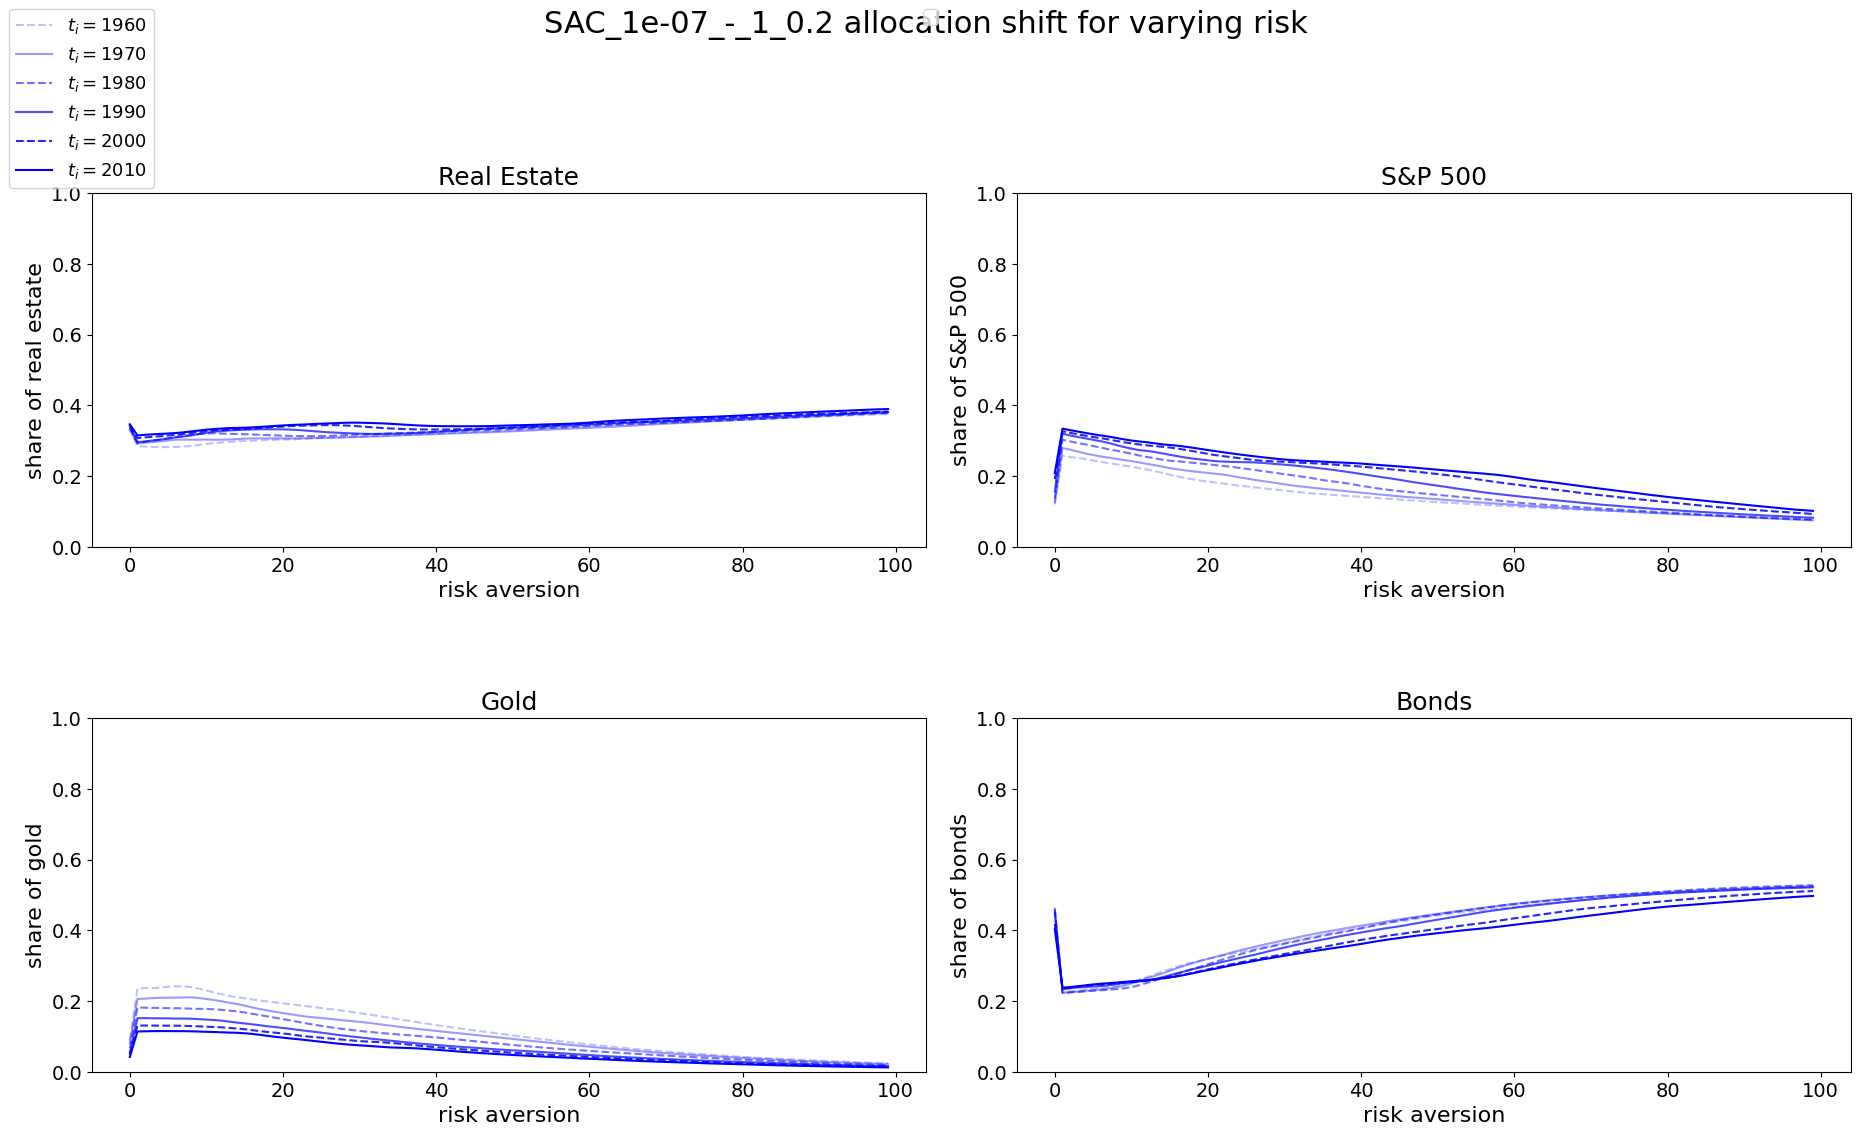

In [ ]:
# plot behavior of SAC with rebalancing
scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
mdls = ['SAC_1e-07_-_1_0.2']
mdl=mdls[0]
for pit in [11, 20, 30, 40, 50, 57] :
	
		try:
			
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			for risk_preference in range(0,100):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
				
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference, 7), deterministic=True)
			
				actions_sum = action[0].sum()
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
				
		
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)

print(risk_actions_bonds)
fig = plt.figure()

ax1 = plt.subplot(2, 2, 1)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_real_estate[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	
	i += 1
ax1.set_title("Real Estate", fontsize=18)
ax1.set_xlabel("risk aversion", fontsize=16)
ax1.set_ylabel("share of real estate", fontsize=16)
ax1.set_ylim([0, 1])

ax2 = plt.subplot(2, 2, 2)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_sp500[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax2.set_title("S&P 500", fontsize=18)
ax2.set_xlabel("risk aversion", fontsize=16)
ax2.set_ylabel("share of S&P 500", fontsize=16)
ax2.set_ylim([0, 1])

ax3 = plt.subplot(2, 2, 3)
i = 0
lines = []
for pit in [11, 20, 30, 40, 50, 57]:
	l = plt.plot(range(0,100), risk_actions_gold[i], color=(0,0,1, 0.25 + i * 0.15 ), linestyle=("-" if i % 2 == 1 else "--"))
	lines.append(l)
	i += 1
ax3.set_title("Gold", fontsize=18)
ax3.set_xlabel("risk aversion", fontsize=16)
ax3.set_ylabel("share of gold", fontsize=16)
ax3.set_ylim([0, 1])

ax4 = plt.subplot(2, 2, 4)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_bonds[i], color=(0,0,1, 0.25 + i * 0.15 ), label="$t_i=${}".format(1950 + 10 * ((pit+3) // 10)), linestyle=("-" if i % 2 == 1 else "--"))
	i += 1
ax4.set_title("Bonds", fontsize=18)
ax4.set_xlabel("risk aversion", fontsize=16)
ax4.set_ylabel("share of bonds", fontsize=16)
ax4.set_ylim([0, 1])
fig.tight_layout(pad=0.0)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('{} allocation shift for varying risk'.format(mdl), fontsize=22, y=1.12)
fig.legend(lines, [1,2,3,4,5,6], loc = 'upper center', ncol=5, labelspacing=0.)
fig.legend(loc="upper left", fontsize=13)
plt.savefig('f_{}_scatter_risk_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

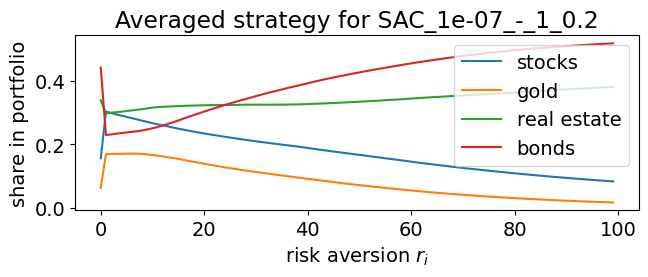

In [48]:
# behavior analysis
scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
mdls = ['SAC_1e-07_-_1_0.2']
mdl=mdls[0]
for pit in [11, 20, 30, 40, 50, 57] :
		
		try:
		
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			for risk_preference in range(0,100):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
				
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference, 7), deterministic=True)
				
				actions_sum = action[0].sum()
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
				
		
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)


fig = plt.figure()

ax1 = plt.subplot(2, 2, 1)
i = 0

stocks_avg = np.average(np.array([risk_actions_sp500[i] for i in range(0,6)]), axis=0)

plt.plot(range(0,100), stocks_avg,  label="stocks")
gold_avg = np.average(np.array([risk_actions_gold[i] for i in range(0,6)]), axis=0)

plt.plot(range(0,100), gold_avg,  label="gold")
real_avg = np.average(np.array([risk_actions_real_estate[i] for i in range(0,6)]), axis=0)

plt.plot(range(0,100), real_avg, label="real estate")





bonds_avg = np.average(np.array([risk_actions_bonds[i] for i in range(0,6)]), axis=0)

plt.plot(range(0,100), bonds_avg,  label="bonds")


plt.xlabel("risk aversion $r_i$")
plt.ylabel("share in portfolio")
plt.legend()
plt.title("Averaged strategy for {}".format(mdl))
plt.savefig('f_{}_average_over_time_risk_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

In [ ]:
# vals = [fine_scores_reb[s] for s in fine_scores_reb.keys()]
# revs = [revenues[s] for s in revenues.keys()]
# acts = [actions[s] for s in actions.keys()]
# print(sorted(zip(vals, fine_scores_reb.keys()), reverse=True))
# #scores["Benchmark"]



# fine_scores_reb["Benchmark"] = 0
# revenues["Benchmark"] = 0

# for i in val_data.iterrows():
# 		env.set_current_observation = i[1].values
# 		try:
# 			#print(env.current_observation)
# 			#print(i[1].values)
# 			env.current_point_in_time = i[1].values[1]
# 			env.risk_preference=i[1].values[2]
# 			env.horizon_preference=i[1].values[3]
# 			#print("risk value is: {}".format(i[1].values[2]))
# 			if i[1].values[2] <= lower_risk_bound:
# 				#print("lower")
# 				fine_scores_reb["Benchmark"] += env._calculate_reward(np.array(benchmark_conservative))
# 			elif i[1].values[2] >= upper_risk_bound:
# 				fine_scores_reb["Benchmark"] += env._calculate_reward(np.array(benchmark_aggresive))
# 				#print("reward is: {}".format(env._calculate_reward(benchmark_aggresive)))
# 				#print("upper")
# 			else:
# 				fine_scores_reb["Benchmark"] += env._calculate_reward(benchmark)
# 				#print("medium")
# 			#revenues["Benchmark"] += env.calculate_revenue(benchmark)
# 		except:
# 			fine_scores_reb["Benchmark"] = 0
# 			revenues["Benchmark"] = 0

# print("Benchmark score is {}".format(fine_scores_reb["Benchmark"]))

[(676.5863080185662, 'SAC_1e-06_-_1_0.3'), (675.4719203697886, 'SAC_1e-06_-_1_0.45'), (597.4993754971043, 'SAC_1e-06_-_1_0.2'), (591.7944204989612, 'SAC_1e-06_-_1_0.35'), (587.3790058652578, 'SAC_1e-06_-_1_0.25'), (582.7566279048923, 'SAC_1e-06_-_1_0.4'), (558.7028804019835, 'SAC_1e-06_-_1_0.1'), (547.309670437426, 'SAC_1e-06_-_1_0.5'), (535.7410794102639, 'SAC_1e-06_-_1_0.6'), (534.879491337307, 'SAC_1e-06_-_1_0.7'), (-117.99132489719517, 'SAC_1e-06_-_1_False')]


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:179: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Benchmark score is -512.8953178791642


In [49]:
# tweak custom environment to train for equally distributed portfolio

import gym
from gym import spaces
import numpy as np
import math

def get_random_integer_between(a,b,c=0):
  np.random.seed(c)
  no = (min(max(np.random.normal(0,1), -4),4)/4) * ((b-a)/2) + a + (b-a)/2
  no = int(round(no,0))
  return no

class CustomEnvReb(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    def __init__(self, data, rebalancing=False, risk_enforcement = 1):
        super(CustomEnvReb, self).__init__()
        self.data = data
        self.rebalancing = rebalancing
        self.current_step = 0
        self.horizon_preference = 5
        self.risk_preference = 50
        self.current_point_in_time = 11
        self.reward_range = (-np.inf, np.inf) 
        self.risk_enforcement = risk_enforcement
   
        self.action_space = spaces.Box(low=0.001, high=1, shape=(4,))
        if rebalancing == "learn":
          self.action_space = spaces.Box(low=0.001, high=1, shape=(5,))
       

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(58, ), dtype=np.float16)
    
    def get_obs_sample(self):
        return self.observation_space.sample()

    def get_random_preferences(self):
      return np.array([get_random_integer_between(0,10), get_random_integer_between(0,100)],dtype=np.float32)

    def set_current_observation(self, observation):
      self.current_observation = observation

    def get_current_observation(self, current_point_in_time=False, risk_preference=False, horizon_preference=False):
      self.current_point_in_time = current_point_in_time if current_point_in_time else get_random_integer_between(11,57, self.current_step)#np.random.randint(11,57)
      self.risk_preference = risk_preference if risk_preference else get_random_integer_between(0,100, self.current_step)#np.random.randint(0,100)   
      self.horizon_preference = horizon_preference if horizon_preference else get_random_integer_between(5,10, self.current_step)#np.random.randint(5,10)
      self.current_asset_data = np.array(self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]].iloc[self.current_point_in_time - 10: self.current_point_in_time].values,dtype=np.float32)
      self.std_devs = []
    
      for c in ["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]:
        self.std_devs.append(self.data[[c]].iloc[self.current_point_in_time - 10: self.current_point_in_time].std().values[0])
      
      self.std_devs = np.array(self.std_devs,dtype=np.float32 )
   
      self.current_observation =  np.concatenate((
        self.current_asset_data.flatten(),
        np.array([self.risk_preference, self.horizon_preference, self.current_point_in_time],dtype=np.float32),
        self.std_devs),
        axis=None
        )

      return self.current_observation


    def reset(self):
      return self.get_current_observation()

    
    def _next_observation(self):
      self.current_step += 1
      self.current_point_in_time = get_random_integer_between(11,57,self.current_step)
      self.risk_preference=get_random_integer_between(0,100,self.current_step)
      self.horizon_preference=get_random_integer_between(5,10,self.current_step)
      next_observation = self.get_current_observation(current_point_in_time=get_random_integer_between(11,57,self.current_step), risk_preference=get_random_integer_between(0,100,self.current_step), horizon_preference=get_random_integer_between(5,10,self.current_step))

      return next_observation

    def _calculate_reward(self, action, *args, **kwargs):
      relevant_timeseries = self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond"]].iloc[self.current_point_in_time: self.current_point_in_time + self.horizon_preference]
      reb_action = 0
      if self.rebalancing == "learn":
        reb_action = action[4]
        action = np.array([0.25, 0.25, 0.25, 0.25])
      action_sum = action.sum()
      asset_allocation = [action[0]/action_sum, action[1]/action_sum, action[2]/action_sum, action[3]/action_sum]

      if self.rebalancing:
        aggregated_timeseries = []
        i = 0
        for step in relevant_timeseries.iterrows():
          if i == 0:
            aggregated_timeseries.append(
              asset_allocation[i] * step[1].values
            ) 
            i += 1
          else:
            resulting_allocation = [aggregated_timeseries[-1][i] / np.array(aggregated_timeseries[-1]).sum() for i in [0,1,2,3]]
            max_deviation = abs(max(([(resulting_allocation[i] - asset_allocation[i])/asset_allocation[i] for i in [0,1,2,3]]), key=abs))
            if (self.rebalancing == "learn" and max_deviation > reb_action) or (self.rebalancing not in [False, "learn"] and max_deviation > self.rebalancing):
              current_portfolio_value = np.array(aggregated_timeseries[-1]).sum()
              rebalanced_portfolio = [asset_allocation[i] * current_portfolio_value for i in [0,1,2,3]]
              aggregated_timeseries.append(
                rebalanced_portfolio * (step[1].values)
              ) 
              
            else:
              # let go
              aggregated_timeseries.append(
                aggregated_timeseries[-1] * (step[1].values)
              ) 
        aggregated_timeseries_calc = pd.Series([i.sum() for i in aggregated_timeseries]).pct_change().values
          # erstes jahr wird ausgenommen, da kein Zuwachs berechenbar
        increments = np.array([1 + i for i in aggregated_timeseries_calc][1:])
        aggregated_timeseries = increments.cumprod()
        # sum allocations over all asset classes to get a 1 dimensional timeseries: 
        # die aggregated timeseries muss in jedem jahr den wertzuwachs zeigen, z.B. +10% -> 1.1, +20% -> 1.2
 
      else:

        increments = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"].values-1) \
        +((action[1] / action.sum())*(relevant_timeseries["gold"].values-1))
        + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"].values-1)) \
            + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"].values-1)) 
        
        aggregated_timeseries = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"].values.cumprod()-1) \
        +((action[1] / action.sum())*(relevant_timeseries["gold"].values.cumprod()-1)) \
          + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"].values.cumprod()-1)) \
            + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"].values.cumprod()-1)) 
        # erstes jahr wird ausgenommen, da kein Zuwachs berechenbar
        #print("final timeseries  w/o rebalancing aa: {}".format(aggregated_timeseries))
        aggregated_timeseries = aggregated_timeseries[1:]
        
      # add "fear of missing out"
      unrepresented_assets_penality = 1
      for act in action:
        unrepresented_assets_penality *= 1 - 5.5* (0.05 - min(act, 0.05))
      if (self.risk_preference * np.array(aggregated_timeseries).std()) != 0:
        vola_factor = 3 * np.array(increments).std()
        if vola_factor == [] or vola_factor == np.nan or math.isnan(vola_factor):
          vola_factor = 0
        reward = list(np.array(aggregated_timeseries))[-1] - ((self.risk_enforcement * self.risk_preference) * vola_factor if vola_factor else 1)
        reward *= unrepresented_assets_penality
      else:
        reward = 0
      if reward == np.nan or math.isinf(reward):
        reward = 0
      else:
        return reward

    def calculate_revenue(self, action, *args, **kwargs):
      relevant_timeseries = self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]].iloc[self.current_point_in_time: self.current_point_in_time + self.horizon_preference]
     
      aggregated_timeseries = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"]-1) \
      +((action[1] / action.sum())*(relevant_timeseries["gold"]-1)) \
         + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"]-1)) \
          + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"]-1)) 
      
      reward = list(aggregated_timeseries.cumprod())[-1]
      
      if reward == np.nan or math.isinf(reward):
        return 0
      else:
        return reward


    def step(self, action):
  
      self.reward = self._calculate_reward(action)
      
      return self._next_observation(), self.reward, self.current_step < 2500, {}
    def render(self, mode='human'):
      pass


        

In [50]:
# training with free rebalancing boundary selection


models = {
	 "SAC":SAC,
	}
fine_scores_learn = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
learning_rates = [1e-7, 1e-6, 1e-5]
batch_sizes = [30]
total_timesteps = 5500
models_1={}

for rebalancing, learning_rate in product(["learn"], learning_rates):
	
	batch_size=1
	model= "SAC"
	risk_enforcement=1.2
	env = CustomEnvReb(data, rebalancing=rebalancing, risk_enforcement=risk_enforcement)
	eval_env = CustomEnvReb(data, rebalancing=rebalancing, risk_enforcement=risk_enforcement)
	stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
	eval_callback = EvalCallback(eval_env, eval_freq=300, callback_after_eval=stop_train_callback, verbose=0)

	print(model)
	n_actions = env.action_space.shape[-1]
	action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
	m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	key = "{}_{}_-_{}_{}".format(model,str(learning_rate), str(batch_size), "learn")
	fine_scores_learn[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m, risk_enforcement=risk_enforcement)
	print("{} score is {}".format(key, fine_scores_learn[key]))
	models_1[key] = m
	

SAC


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/gym/core.py:269: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:182: DeprecationWarning: The truth v

local variable 'score' referenced before assignment


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


SAC_1e-07_-_1_learn score is 702.4230233959892
SAC
local variable 'score' referenced before assignment
SAC_1e-06_-_1_learn score is 522.608001957684
SAC
local variable 'score' referenced before assignment
SAC_1e-05_-_1_learn score is 489.1276262463764


In [250]:
# calculate benchmark
vals_learn = [fine_scores_learn[s] for s in fine_scores_learn.keys()]
revs = [revenues[s] for s in revenues.keys()]
acts = [actions[s] for s in actions.keys()]


fine_scores_learn["Benchmark"] = 0
revenues["Benchmark"] = 0

for i in val_data.iterrows():
		env.set_current_observation = i[1].values
		try:
			fine_scores_learn["Benchmark"] += env._calculate_reward(benchmark)
			revenues["Benchmark"] += env.calculate_revenue(benchmark)
		except:
			fine_scores_learn["Benchmark"] = 0
			revenues["Benchmark"] = 0
print(sorted(zip(vals_learn, fine_scores_learn.keys()), reverse=True))

[(702.4230233959892, 'SAC_1e-07_-_1_learn'), (522.608001957684, 'SAC_1e-06_-_1_learn'), (489.1276262463764, 'SAC_1e-05_-_1_learn')]


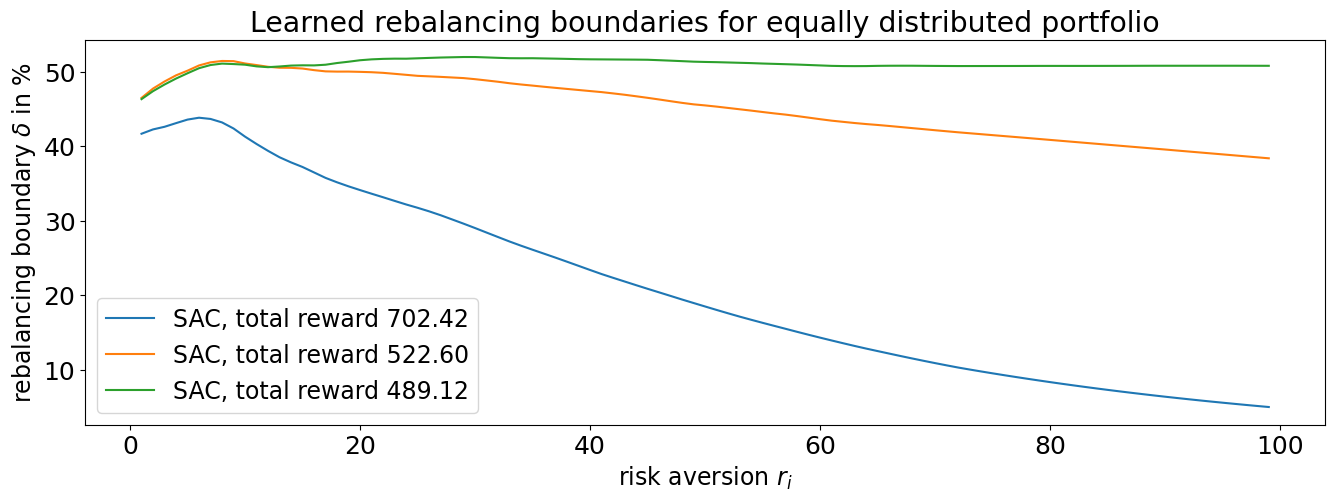

In [254]:
# plot rebalancing boundary selection behavior

env = CustomEnv(data, rebalancing="learn", risk_enforcement= risk_enforcement)

learned_rebalancing = []
for risk in range (1,100):
    reb = models_1['SAC_1e-07_-_1_learn'].predict(env.get_current_observation(current_point_in_time=11, risk_preference=risk, horizon_preference=7), deterministic=True)[0][1]
    learned_rebalancing.append(reb)
plt.plot(range(1,100), [100 * x for x in learned_rebalancing], label=r'SAC, total reward 702.42')
learned_rebalancing = []
for risk in range (1,100):
    reb = models_1['SAC_1e-06_-_1_learn'].predict(env.get_current_observation(current_point_in_time=11, risk_preference=risk, horizon_preference=7), deterministic=True)[0][1]
    learned_rebalancing.append(reb)
plt.plot(range(1,100), [100 * x for x in learned_rebalancing], label=r'SAC, total reward 522.60')
learned_rebalancing = []
for risk in range (1,100):
    reb = models_1['SAC_1e-05_-_1_learn'].predict(env.get_current_observation(current_point_in_time=11, risk_preference=risk, horizon_preference=7), deterministic=True)[0][1]
    learned_rebalancing.append(reb)
plt.plot(range(1,100), [100 * x for x in learned_rebalancing], label=r'SAC, total reward 489.12')

plt.title("Learned rebalancing boundaries for equally distributed portfolio")
plt.xlabel("risk aversion $r_i$")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel(r'rebalancing boundary $\delta$ in %')
plt.legend()
plt.rcParams.update({'font.size': 17})
plt.savefig('f_learned_rebalancing_boundaries.pdf', bbox_inches='tight' )


[0.3906498  0.08655267 0.2715197  0.2512779  0.19277494]


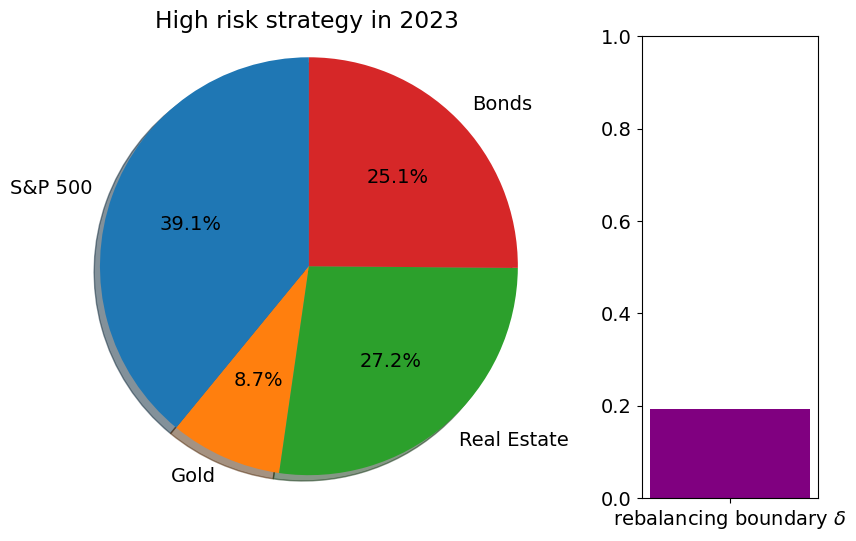

In [117]:
# plot asset allocation suggestions for 2023
risk = -1
action = models_1['SAC_1e-07_-_1_learn'].predict(env.get_current_observation(current_point_in_time=69, risk_preference=risk, horizon_preference=25), deterministic=True)[0]
action = action / np.array(action[:4]).sum()
print(action)

fig1, ax1 = plt.subplots(figsize=(10,6), ncols=2, nrows=1,gridspec_kw={'width_ratios':[3,1]})
ax1 = plt.subplot(1,2,1, )
ax1.pie(action[:4], labels=["S&P 500", "Gold",'Real Estate', 'Bonds'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title("High risk strategy in 2023")
ax2 = plt.subplot(1,2,2)
ax2.bar(height=action[4], x=r"rebalancing boundary $\delta$", color="purple")
ax2.set_ylim(0,1)
plt.savefig('f_aggr_2023.pdf', bbox_inches='tight')



In [255]:


models = {
	
	 "SAC":SAC,
	
	
	}
fine_scores_learn_free = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
learning_rates = [1e-7, 1e-6, 1e-5]
batch_sizes = [30]
total_timesteps = 5500
models_1={}

for rebalancing, learning_rate in product(["learn"], learning_rates):
	
	batch_size=1
	model= "SAC"
	risk_enforcement=1.2
	env = CustomEnv(data, rebalancing=rebalancing, risk_enforcement=risk_enforcement)
	eval_env = CustomEnv(data, rebalancing=rebalancing, risk_enforcement=risk_enforcement)
	stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
	eval_callback = EvalCallback(eval_env, eval_freq=300, callback_after_eval=stop_train_callback, verbose=0)

	print(model)
	n_actions = env.action_space.shape[-1]
	action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
	m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	key = "{}_{}_-_{}_{}".format(model,str(learning_rate), str(batch_size), "learn")
	fine_scores_learn_free[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m, risk_enforcement=risk_enforcement)
	print("{} score is {}".format(key, fine_scores_learn_free[key]))
	models_1[key] = m
	


	



SAC


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/gym/core.py:269: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of fre

local variable 'score' referenced before assignment
SAC_1e-07_-_1_learn score is 702.5970889906514
SAC
local variable 'score' referenced before assignment
SAC_1e-06_-_1_learn score is 519.3844570387109
SAC
local variable 'score' referenced before assignment
SAC_1e-05_-_1_learn score is 528.3111560367748


<Figure size 2600x800 with 0 Axes>

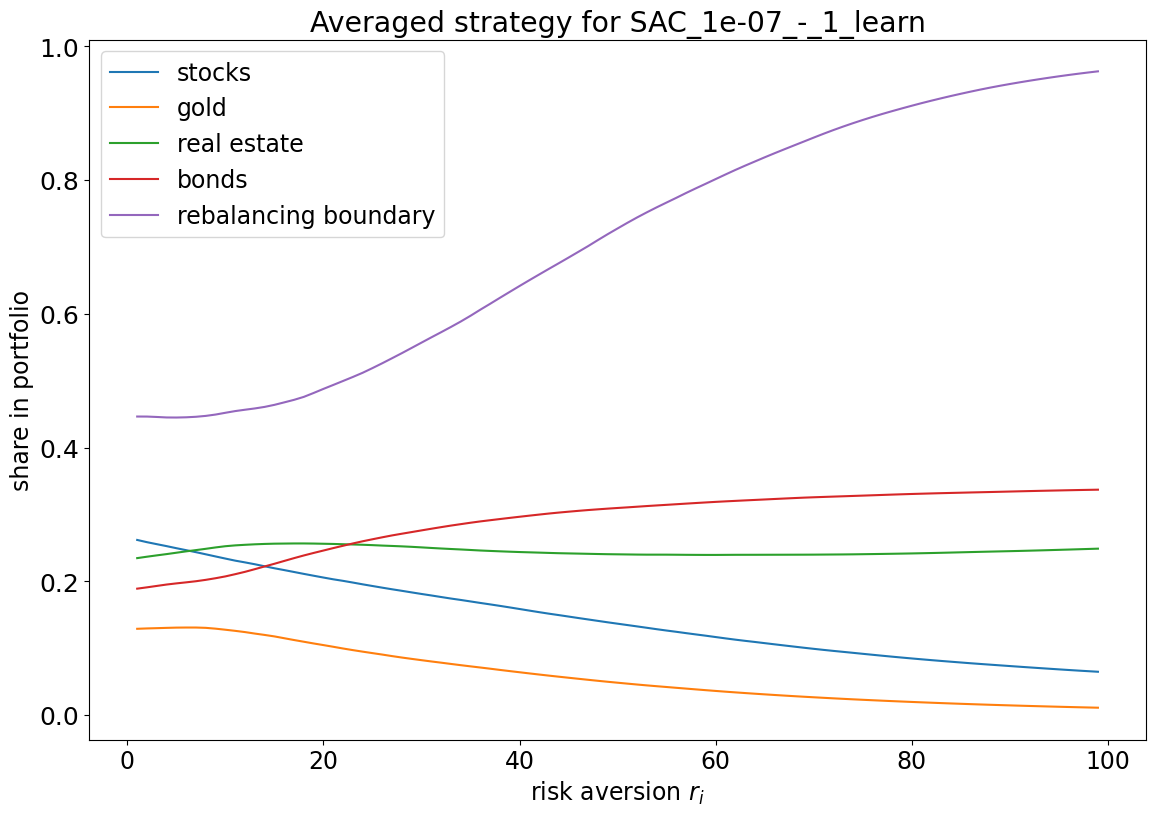

In [265]:
# plot averaged strategy with rebalancing boundary curve
scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
risk_actions_reb=[]
mdls = ['SAC_1e-07_-_1_learn']
mdl=mdls[0]
for pit in [11, 20, 30, 40, 50, 57] :
		
    try:
       
        risk_actions_sp500_inc = []
        risk_actions_gold_inc = []
        risk_actions_real_estate_inc = []
        risk_actions_bonds_inc = []
        risk_actions_reb_inc=[]
        for risk_preference in range(1,100):
            env.current_point_in_time = pit
            env.risk_preference=risk_preference
            env.horizon_preference=7
            action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference, 7), deterministic=True)
            actions_sum = action[0].sum()
            risk_actions_sp500_inc.append(action[0][0]/actions_sum)
            risk_actions_gold_inc.append(action[0][1]/actions_sum)
            risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
            risk_actions_bonds_inc.append(action[0][3]/actions_sum)
            risk_actions_reb_inc.append(action[0][4])
    
        risk_actions_sp500.append(risk_actions_sp500_inc)
        risk_actions_gold.append(risk_actions_gold_inc)
        risk_actions_real_estate.append(risk_actions_real_estate_inc)
        risk_actions_bonds.append(risk_actions_bonds_inc)
        risk_actions_reb.append(risk_actions_reb_inc)

    except Exception as e:
        print(e)
        scores_risk.append(0)

fig = plt.figure()
plt.figure(figsize=(30,20), facecolor="white")
ax1 = plt.subplot(2, 2, 1)
i = 0

stocks_avg = np.average(np.array([risk_actions_sp500[i] for i in range(0,6)]), axis=0)

plt.plot(range(1,100), stocks_avg,  label="stocks")
gold_avg = np.average(np.array([risk_actions_gold[i] for i in range(0,6)]), axis=0)

plt.plot(range(1,100), gold_avg,  label="gold")
real_avg = np.average(np.array([risk_actions_real_estate[i] for i in range(0,6)]), axis=0)

plt.plot(range(1,100), real_avg, label="real estate")





bonds_avg = np.average(np.array([risk_actions_bonds[i] for i in range(0,6)]), axis=0)

plt.plot(range(1,100), bonds_avg,  label="bonds")

reb_avg = np.average(np.array([risk_actions_reb[i] for i in range(0,6)]), axis=0)

plt.plot(range(1,100), reb_avg,  label="rebalancing boundary")

plt.xlabel("risk aversion $r_i$")
plt.ylabel("share in portfolio")
plt.legend()
plt.title("Averaged strategy for {}".format(mdl))
plt.savefig('f_{}_average_over_time_reb_learn.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

[[0.31813723, 0.20062582, 0.20223556, 0.20430785, 0.20524034, 0.20569694, 0.20639054, 0.20584613, 0.2063539, 0.20819011, 0.21116534, 0.21499091, 0.21887524, 0.22234274, 0.22608142, 0.22944418, 0.23369585, 0.23690313, 0.24010004, 0.2433155, 0.24576508, 0.24812047, 0.24998023, 0.25161317, 0.25364715, 0.25564167, 0.25724882, 0.25891948, 0.26055875, 0.26231351, 0.264383, 0.26647237, 0.26848164, 0.27050623, 0.2725306, 0.2744342, 0.2763078, 0.27797493, 0.2795413, 0.2811059, 0.2827333, 0.2844521, 0.2860928, 0.2877524, 0.28947684, 0.29124323, 0.293264, 0.29529506, 0.29701295, 0.29866135, 0.30030453, 0.3018885, 0.30344522, 0.30499586, 0.3065406, 0.3081102, 0.30956525, 0.31101498, 0.31245944, 0.31389835, 0.31531766, 0.3167303, 0.31813723, 0.31942868, 0.32065156, 0.32187748, 0.32312462, 0.3243854, 0.32564104, 0.32689148, 0.32813665, 0.32933313, 0.33052558, 0.3316969, 0.332862, 0.3340224, 0.33517814, 0.33632913, 0.33748043, 0.3386383, 0.33979166, 0.34094012, 0.34208393, 0.34322277, 0.34435692, 0.3

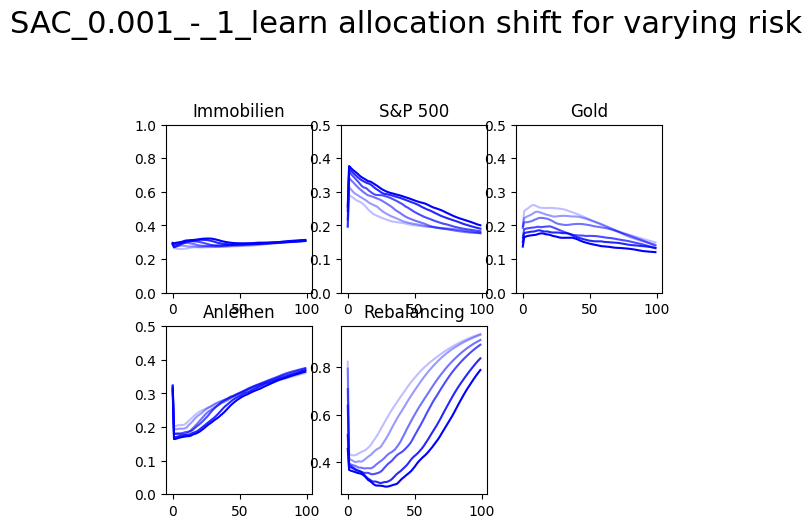

In [43]:
import matplotlib.pyplot as plt
scores_risk = []
risk_actions_sp500 = []
risk_actions_gold = []
risk_actions_real_estate = []
risk_actions_bonds = []
risk_actions_reb = []
mdls = ['A2C_0.0001_False_5','SAC_0.001_-_1_learn',"SAC_0.01_-_30"]
mdl=mdls[1]
for pit in [11, 20, 30, 40, 50, 57] :
		try:
			risk_actions_sp500_inc = []
			risk_actions_gold_inc = []
			risk_actions_real_estate_inc = []
			risk_actions_bonds_inc = []
			risk_actions_reb_inc = []
			for risk_preference in range(0,100):
				env.current_point_in_time = pit
				env.risk_preference=risk_preference
				env.horizon_preference=7
				action = models_1[mdl].predict(env.get_current_observation(env.current_point_in_time,risk_preference, 7), deterministic=True)
				actions_sum = action[0][:4].sum()
				risk_actions_sp500_inc.append(action[0][0]/actions_sum)
				risk_actions_gold_inc.append(action[0][1]/actions_sum)
				risk_actions_real_estate_inc.append(action[0][2]/actions_sum)
				risk_actions_bonds_inc.append(action[0][3]/actions_sum)
				risk_actions_reb_inc.append(action[0][4])
		
			risk_actions_sp500.append(risk_actions_sp500_inc)
			risk_actions_gold.append(risk_actions_gold_inc)
			risk_actions_real_estate.append(risk_actions_real_estate_inc)
			risk_actions_bonds.append(risk_actions_bonds_inc)
			risk_actions_reb.append(risk_actions_reb_inc)

		except Exception as e:
			print(e)
			scores_risk.append(0)

print(risk_actions_bonds)
fig = plt.figure()

ax1 = plt.subplot(2, 3, 1)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_real_estate[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax1.set_title("Immobilien")
ax1.set_ylim([0, 1])

ax2 = plt.subplot(2, 3, 2)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_sp500[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax2.set_title("S&P 500")
ax2.set_ylim([0, .5])

ax3 = plt.subplot(2, 3, 3)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_gold[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax3.set_title("Gold")
ax3.set_ylim([0, .5])

ax4 = plt.subplot(2, 3, 4)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_bonds[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax4.set_title("Anleihen")
ax4.set_ylim([0, .5])
ax5 = plt.subplot(2, 3, 5)
i = 0
for pit in [11, 20, 30, 40, 50, 57]:
	plt.plot(range(0,100), risk_actions_reb[i], color=(0,0,1, 0.25 + i * 0.15 ))
	i += 1
ax5.set_title("Rebalancing")
#ax5.set_ylim([0, .5])

fig.suptitle('{} allocation shift for varying risk'.format(mdl), fontsize=22, y=1.12)
plt.savefig('{}_scatter_risk_dep_allocs.pdf'.format(mdl), bbox_inches='tight' )
plt.show()		

In [ ]:

# plot top average strategies
print(scores)
plt.rcParams["figure.figsize"] = (20,30)
labels = ['S&P 500', 'Gold', 'Real Estate', "Gov. Bonds"]
sorted_by_reward = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
fig, axs = plt.subplots(4)
k = 0
m = 0
l=0
for mdl in list(['A2C_1e-05_False_10', 'PPO1_1e-05_-_30', 'DDPG_1e-05_-_1', 'SAC_0.01_-_1', ]):#list(sorted_by_reward.keys())[-3:]:
        
        axs[m].pie(average_actions[mdl],
                shadow=True, startangle=90, colors=["red", "orange", "blue", "green"])
        lbls = [f'{l}, {(s / average_actions[mdl].sum() * 100):0.1f}%' for l, s in zip(labels, average_actions[mdl])]
        axs[m].legend(lbls, loc='upper left',
           fontsize=10)
        axs[m].title.set_text(mdl)
        m+=1
       
     

In [ ]:
scores = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0

learning_rates = [0.001, 0.00001, 0.0000001]
batch_sizes = [1, 10, 30]
total_timesteps = 10000


	
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
eval_callback = EvalCallback(eval_env, eval_freq=500, callback_after_eval=stop_train_callback, verbose=1)
n_actions = env.action_space.shape[-1]
m = SAC('MlpPolicy',env, learning_rate=0.00001, batch_size=3, seed=1)
m.learn(total_timesteps=total_timesteps, callback=eval_callback)
key = "{}_{}_-_{}".format("SAC",str(learning_rate), str(batch_size))
scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)

scores

In [ ]:
# BACKUP - TO BE CONTINUED: model konversion to onnx format

import os.path
import sys
from os import system

import gym
import torch
#import torchsummary
import tensorflow as tf
import onnx
from onnx_tf.backend import prepare


class OnnxablePolicy(torch.nn.Module):
  def __init__(self,  actor):
      super(OnnxablePolicy, self).__init__()
      self.actor = torch.nn.Sequential(actor.latent_pi, actor.mu)

  def forward(self, observation):
      return self.actor(observation)

print('Exporting to ONNX...')
onnxable_model = OnnxablePolicy(m.policy.actor)
m.policy.to("cpu")
m.policy.eval()
print(str(onnxable_model.actor))
obs = env.observation_space
dummy_input = torch.FloatTensor(obs.sample().reshape(1, -1))

torch.onnx.export(onnxable_model, dummy_input, "mdl.onnx",
                    input_names=['input'],
                    output_names=['output'],
                    opset_version=9, verbose=True)


In [ ]:
print(total_score)

In [ ]:


import yfinance as yf

# Lange Aktienhistorie -> GDP Zeitreihen, abweichung etwa 2.3% ?

acwi = yf.Ticker("SPY")

# get stock info
acwi.history(period="max")

In [ ]:
#Gold since 2000
acwi = yf.Ticker("GC%3DF")

# get stock info
acwi.history(period="max")